# 1. Method description

In this method we run 2 executions of KMeans in parallel:
- The first one runs on the full dataset, and performs A, and then B. A -> B
- The second one runs over a subset of the dataset, and performs A, and then B, multiple times. We describe this as a-> b -> a -> b -> ... -> b. We use small a,b to indicate we are using a subset of the dataset.

We then compute:
- L_slow, the average squared distance from each point to its centroid, using the centroids obtained from the first slow execution
- L_fast, the average squared distance from each point to its centroid, using the centroids obtained from the second fast execution

Afterwards, we compare L_slow and L_fast: we select the centroids of the lowest one.

The idea is that we can distinguish 2 phases in KMeans:
- the first phase we try to move the centroids from the initialization points near to the respective clusters. We may not need the whole dataset in this phase, and that's why the second and faster execution of KMeans may help
- the second phase starts when we almost found the correct position of the centroids and the respective clusters. We are not trying to converge by fixing the last datapoints which are not correctly classified. In this phase is more critical to use the whole dataset, since we need to make small updates of the centroids, which are critical for the convergence.

Let's call L the average squared distance between datapoints and their centroids.

We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. *In this case we may switch to only data parallelism.*

In [1]:
%load_ext autoreload
%autoreload 2
from utils.helpers import generate_clusters, timeseries_plot, load_datasets, generate_complex_datasets, estimate_optimal_centroids, load_downloaded_datasets, agg_and_plot, fit_linear_regression, find_bad_initalization
from utils.KMeans import KMeans, getLables, getCentroids, getAvgDist, KMeans_sketching
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
from sklearn.cluster import KMeans as KMeans_sk
import pickle
from time import process_time_ns

# 2. Measurements L_slow, L_fast, L_diff 

In this section we study how L_slow - L_fast evolves during the KMeans execution.

As we said before:
We expect that:
- L_slow is going to be greater than L_fast in the first phase, so we will benefit from the execution of the second fast run.
- L_slow is going to be less than L_fast in the second phase, so we will no more benefit from the execution of the second fast run. 

Let's call L_diff = (L_slow - L_fast).

We therefore **expect to see L_diff increasing** during the convergence of KMeans.

> ! **Implementation**: In this measurements the KMeans_sketching algorithm **is not picking the best centroids between the slow execution and the fast execution**. We always keep the centroids of the slow execution, since we just want to see if generally the fast execution gives good prediction of the centroids to use.


---

It is important to have sufficient `n` datapoints in order to have sufficient datapoints also in the **subsampling**.

## 2.1 Single execution

In [33]:
# set seed = 0
seed = 0
np.random.seed(seed)
# define parameters
n = 10000
d = 2
k = 3
subsample_size = 0.01
# create synthetic dataset: i.e: k gaussian distributions
true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)
# set output path
path = './data/sketching/sketching_2_1.csv'

In [34]:
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path=path, measure=True)
# read .csv
df = pd.read_csv(path)
# estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
# add L_opt
df['L_opt'] = getAvgDist(X, opt_centroids)

# update .csv with L_opt
df.to_csv(path)

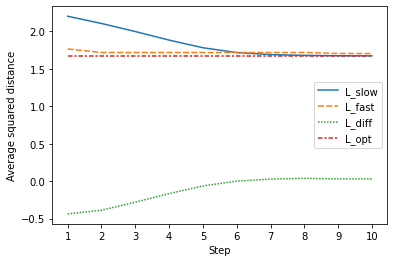

<AxesSubplot:xlabel='Step', ylabel='Average squared distance'>

In [35]:
# read .csv
df = pd.read_csv(path)

# timeseries plot
timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step',
                ylabel='Average squared distance',
                save = True,
                path="./figures_svg/plots_sketching/figure_section_2_1.svg"
               )

As expected we can see how:
- L_slow is greater than L_fast in the first phase.
- L_slow is less than L_fast in the second phase.

and as consequence **L_diff is increasing**.

## 2.2 Multiple executions - synthetic dataset

### 2.2.1 Varying n, d

We check now if the behaviour of the curves change for different synthetic datasets, with `n` (number of datapoints) and `d` (dimension of each datapoint) varying.

What we expect to see is that the behaviour is going to be the same for any combination of `n` and `d` since:
- `n` only increases the density of datapoints but not their distribution
- in the **synthetic dataset** we have a gaussian distribution in `d` dimensions, whatever is `d`

We take:
- `n` in the range [10^4, 10^6]
- `d` in the range [2, 5]

In [46]:
number_n = 4
number_d = 4
seed = 0
k = 3
run = False
subsample_size = 0.01

n:  10000.0
n:  46415.88833612782
n:  215443.46900318822
n:  1000000.0


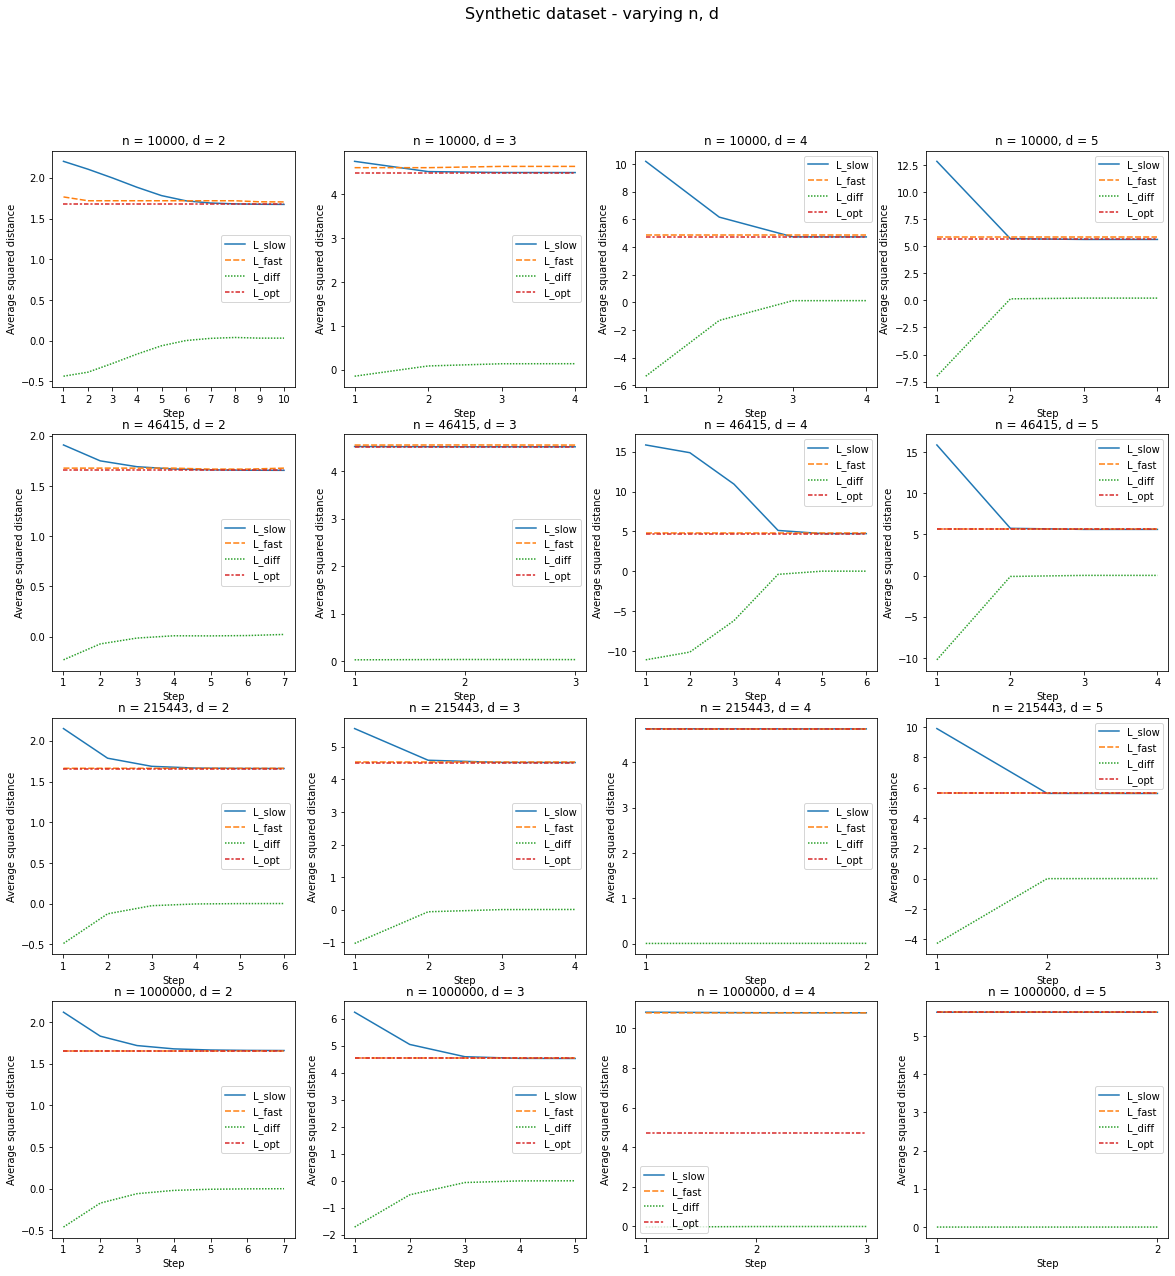

In [47]:
fig, axs = plt.subplots(number_n, number_d, figsize=(20, 20))
for i, n in enumerate(np.logspace(4, 6, num = number_n)):
    print('n: ', n)
    for j, d in enumerate(np.arange(number_d) + 2):
        # cast to int
        n = int(n)
        d = int(d)
        # set output path
        path = f'./data/sketching/sketching_2_2_n_{n}_d_{d}.csv'
        
        if run:
            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

            # run KMeans_sketching
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True)
        
            # read .csv
            df = pd.read_csv(path)

            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
            
            # add L_opt
            df['L_opt'] = getAvgDist(X, opt_centroids)

            # update .csv with L_opt
            df.to_csv(path)
        
        # read .csv
        df = pd.read_csv(path)
        
        # create subplot
        axs[i, j].set_title(f'n = {n}, d = {d}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance', ax = axs[i, j], show=False)

fig.suptitle('Synthetic dataset - varying n, d', fontsize=16)        
# plt.savefig('./figures/sketching_2_2_n_d_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_2_2_1.svg", format="svg", bbox_inches='tight')
plt.show()

From the plots we can see how the behaviour remains always the same: sometimes is more accentuated, other times less.

In particular we observe how the `L_fast_list` is constant during the KMeans execution.
This behaviour can be explained by the fact that the fast execution, given the centroids of the slow execution, manages always to converge to its personal solution in `floor(1/subsample_size)` steps.

We can think that this happens because the data distribution of all clusters follows a Gaussian distribution, therefore even with a subset of the datapoints it's easy to find the centroid position, since clusters are well defined.

### 2.2.2 Varying k, k_imposed

We check now if the behaviour of the curves change for different synthetic datasets, with `k` (number of clusters in the dataset) and `k_imposed` (number of clusters imposed to KMeans) varying.

We take:
- `k` in the range [3, 7]
- `k_imposed` in the range [3, 7]

In [116]:
number_k = 4
number_k_imp = 4
seed = 0
n = int(1e5)
d = 3
run = False
subsample_size = 0.01

k 3
	 k imposed 3
	 k imposed 4
	 k imposed 5
	 k imposed 6
k 4
	 k imposed 3
	 k imposed 4
	 k imposed 5
	 k imposed 6
k 5
	 k imposed 3
	 k imposed 4
	 k imposed 5
	 k imposed 6
k 6
	 k imposed 3
	 k imposed 4
	 k imposed 5
	 k imposed 6


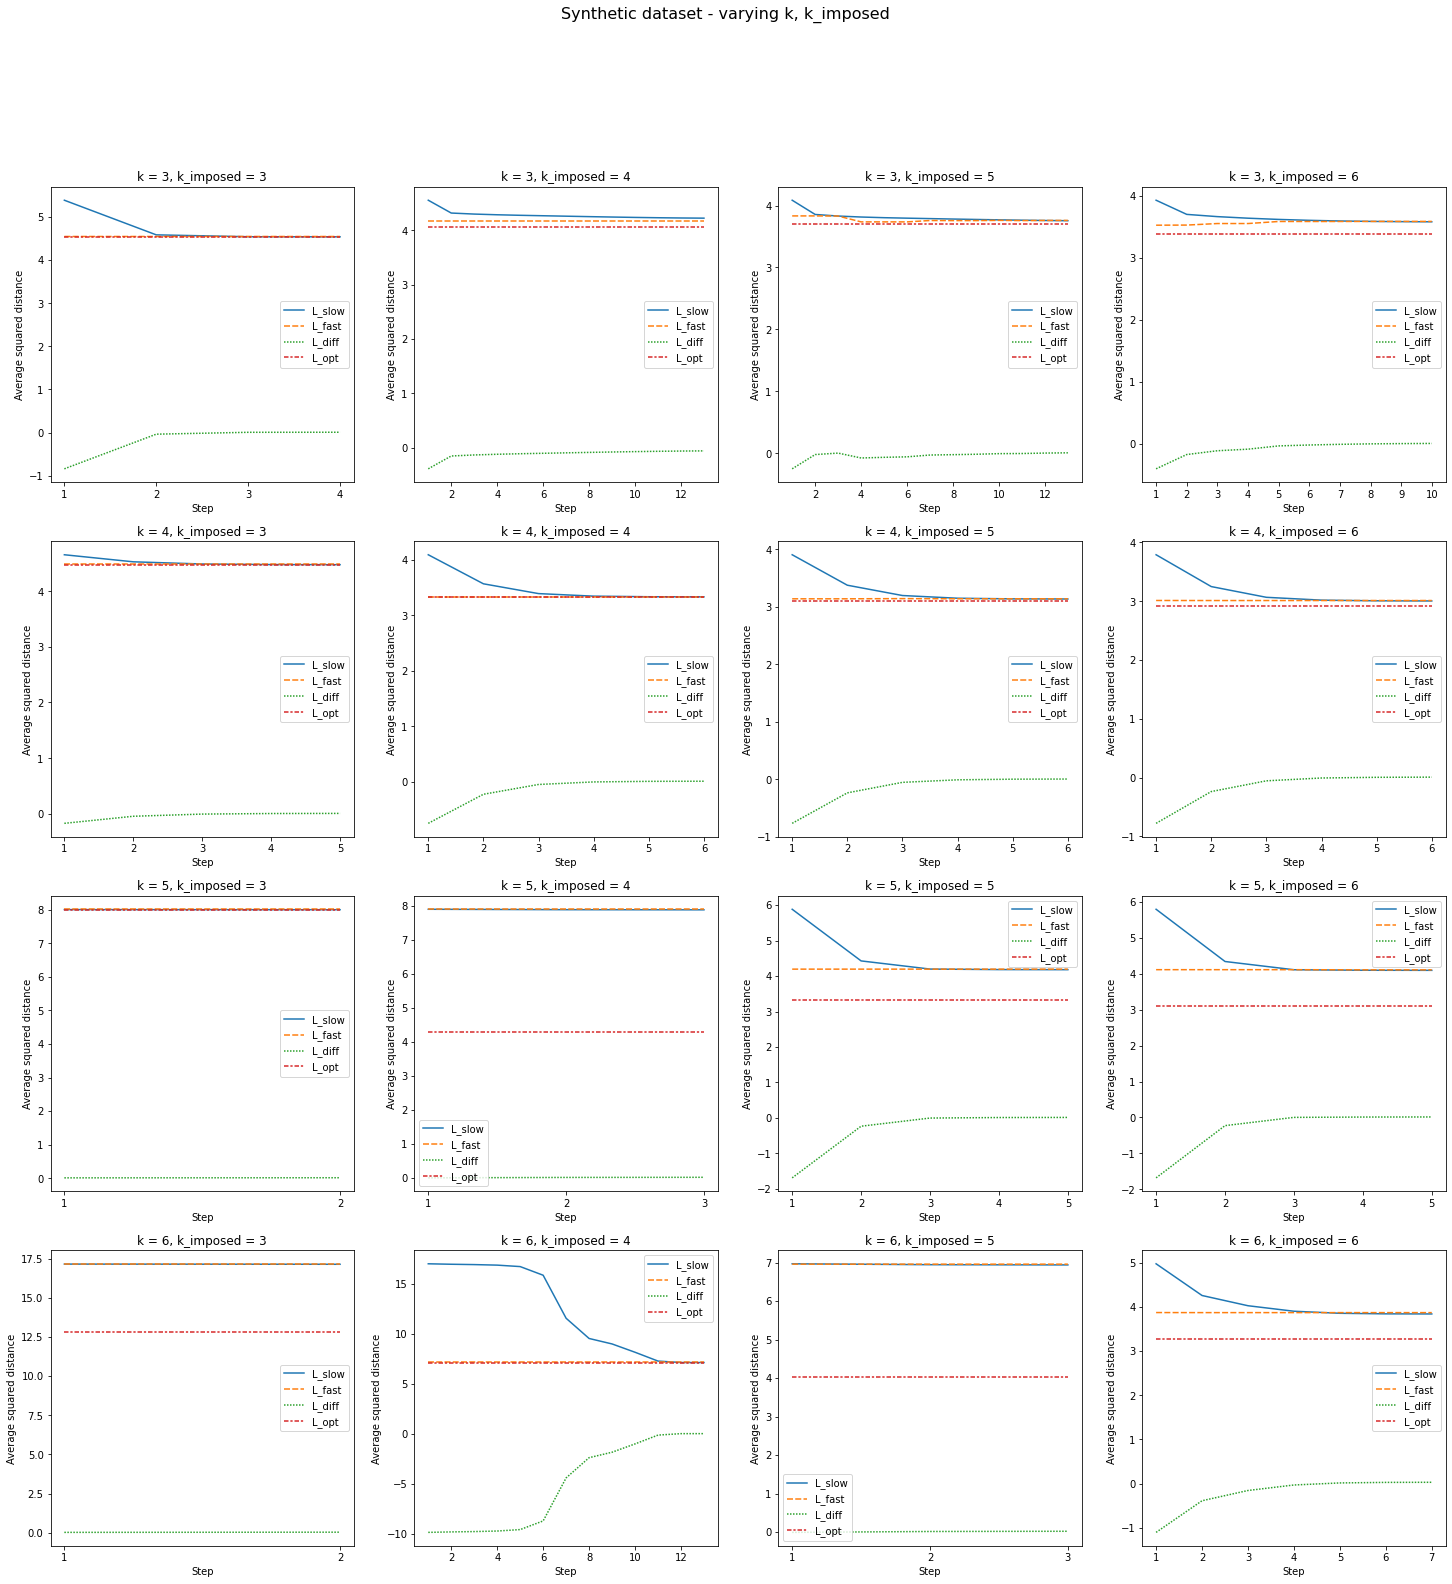

In [117]:
fig, axs = plt.subplots(number_k, number_k_imp, figsize=(25, 25))
for i, k in enumerate(np.arange(number_k) + 3):
    print('k', k)
    for j, k_imposed in enumerate(np.arange(number_k_imp) + 3):
        print('\t k imposed', k_imposed)
        # cast to int
        k = int(k)
        k_imposed = int(k_imposed)
        
        # set output path
        path = f'./data/sketching/sketching_2_2_k_{k}_k_imposed_{k_imposed}.csv'
        if run:
            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

            # run KMeans_sketching
            labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True)
        
            # read .csv
            df = pd.read_csv(path)

            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k_imposed, seed = 0,n_init = 50, tol = 1e-6)

            # add L_opt
            df['L_opt'] = getAvgDist(X, opt_centroids)

            # update .csv with L_opt
            df.to_csv(path)
        
        # read .csv
        df = pd.read_csv(path)
        
        # create subplot
        axs[i, j].set_title(f'k = {k}, k_imposed = {k_imposed}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance', ax = axs[i, j], show=False)
        
fig.suptitle('Synthetic dataset - varying k, k_imposed', fontsize=16)        
#plt.savefig('./figures/sketching_2_2_k_k_imposed_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_2_2_2.svg", format="svg", bbox_inches='tight')
plt.show()

In this case we can see dome differences, especially for:
- k = 5, k_imposed = 4
- k = 5, k_imposed = 6
- k = 6, k_imposed = 4

In this plots, we see how `L_fast` is no more constant. However we can see how **in the fast execution, we reduce the value of L earlier than the slow execution.**

## 2.3 Multiple executions - real datasets

We now execute the same code using now real datasets to see if the behaviour stays consistent.

In this section originally we:
1. did NOT resample X at each step
2. did NOT use traces
3. did NOT use centroid resampling

In [83]:
# load datasets
query = "NumberOfInstances > 10000 &\
         NumberOfInstances < 100000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

dataset number 0
dataset number 1
dataset number 2
dataset number 3
dataset number 4
dataset number 5
dataset number 6
dataset number 7
dataset number 8
dataset number 9


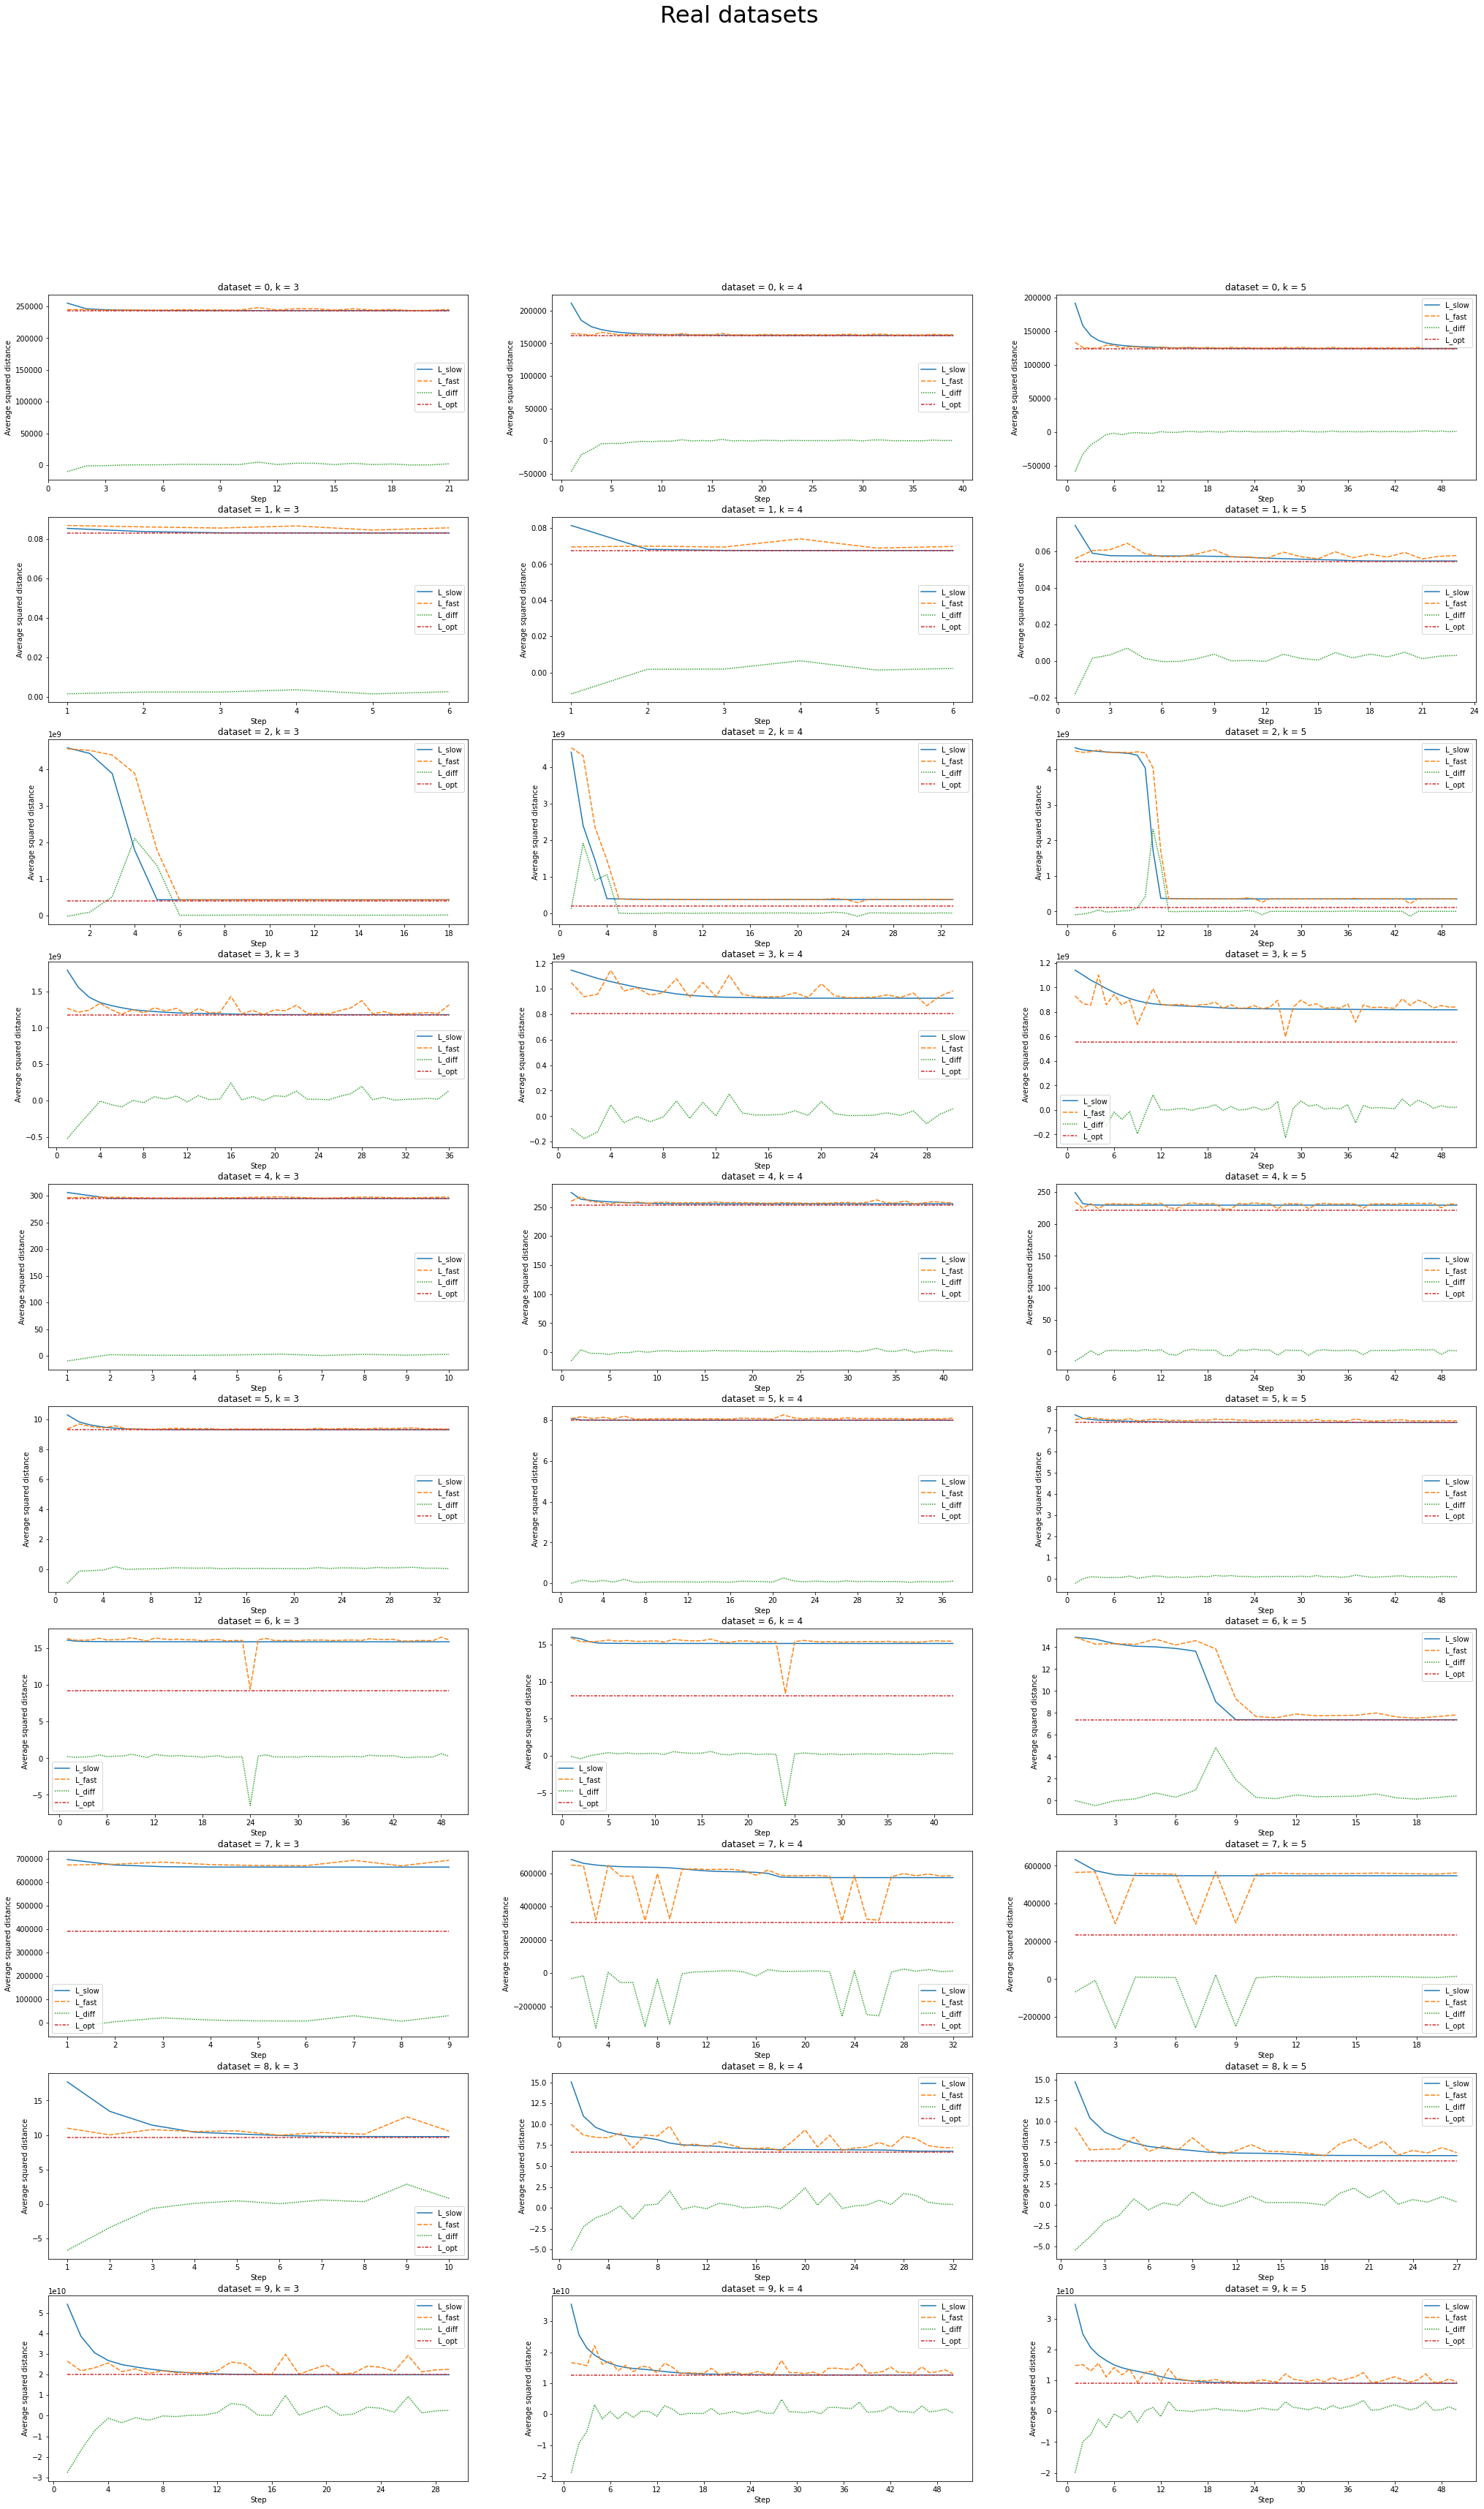

In [87]:
# set seed
seed = 0
subsample_size = 0.01
run = False

fig, axs = plt.subplots(len(X_list), 3, figsize=(35, 55))
for i, X in enumerate(X_list):
    print('dataset number', i)
    # set parameters
    n, d = X.shape
    for j, k in enumerate(range(3,6)):
        # set output path
        path = f'./data/sketching/sketching_2_3_dataset_{i}_k_{k}.csv'
        if run:            
            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True)
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best=False, resampling=True, trace=False, tol=1e-9, resample_centroid=False)

            # read .csv
            df = pd.read_csv(path)

            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
            
            # add L_opt
            df['L_opt'] = getAvgDist(X, opt_centroids)
            
            # update .csv with L_opt
            df.to_csv(path)
            
        # read .csv
        df = pd.read_csv(path)
            
        # create subplot
        axs[i, j].set_title(f'dataset = {i}, k = {k}')
        timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance', ax = axs[i, j], show=False)
        
fig.suptitle('Real datasets', fontsize=32)        
# plt.savefig('./figures/sketching_2_3_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_2_3.svg", format="svg", bbox_inches='tight')
plt.show()

From the plots we can observe how the **fast execution** is able in most cases to **lead to centroids minimizing the average squared distance earlier than the slow execution**.

Of course, in some cases as:
- dataset = 7, k = 3
- dataset = 7, k = 5

The centroids proposed by the **fast execution**  lead to a greater inertia (i.e: average squared distance) than the **slow execution**  in the last steps, since **in the last steps we need to whole dataset to find the the perfect position of the centroids to minimize inertia**.

In general, our expectations are met by the plots.

# 3. Measuring steps

## 3.1 Single execution

In [5]:
# set seed = 0
seed = 0
np.random.seed(seed)
# define parameters
n = 100000
d = 2
k = 3
subsample_size = 0.01
# create synthetic dataset
true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

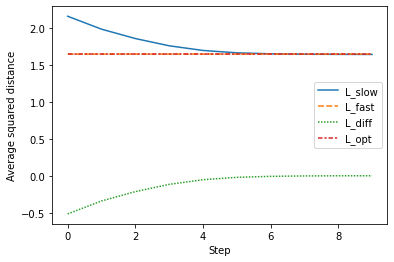

array([9], dtype=int64)

In [8]:
# set output path
path = './data/sketching/sketching_3_1_choose_false.csv'
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path = path, measure = True, choose_best = False)
# read .csv
df = pd.read_csv(path)
# estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
# add L_opt
df['L_opt'] = getAvgDist(X, opt_centroids)
# timeseries plot
timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance')
# number of steps
df['steps'].unique()

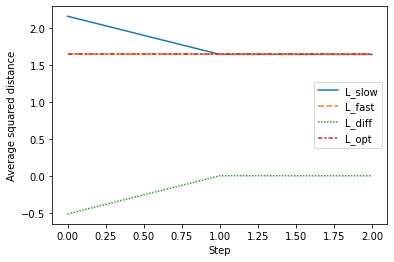

array([2], dtype=int64)

In [9]:
# set output path
path = './data/sketching/sketching_3_1_choose_true.csv'
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path = path, measure = True, choose_best = True)
# read .csv
df = pd.read_csv(path)
# estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
# add L_opt
df['L_opt'] = getAvgDist(X, opt_centroids)
# timeseries plot
timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance')
# number of steps
df['steps'].unique()

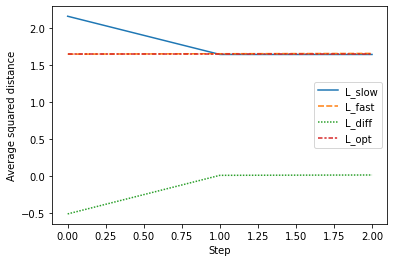

array([2], dtype=int64)

In [10]:
# set output path
path = './data/sketching/sketching_3_1_choose_true_resampling.csv'
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path = path, measure = True, choose_best = True, resampling=True)
# read .csv
df = pd.read_csv(path)
# estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
# add L_opt
df['L_opt'] = getAvgDist(X, opt_centroids)
# timeseries plot
timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance')
# number of steps
df['steps'].unique()

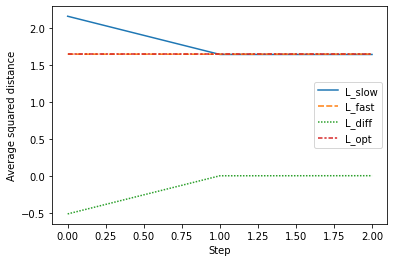

array([2], dtype=int64)

In [11]:
# set output path
path = './data/sketching/sketching_3_1_choose_true_resampling_trace.csv'
# entire execution
labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save=True, path = path, measure = True, choose_best = True, resampling=True, trace = True)
# read .csv
df = pd.read_csv(path)
# estimate optimal centroids
opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
# add L_opt
df['L_opt'] = getAvgDist(X, opt_centroids)
# timeseries plot
timeseries_plot(df[['L_slow', 'L_fast', 'L_diff', 'L_opt']], xlabel='Step', ylabel='Average squared distance')
# number of steps
df['steps'].unique()

We observe how the number of steps dicreases with the sketching technique, when we choose the best centroids between the slow and the fast execution.

In particular we can observe further improvements if:
- we do resampling at each KMeans iteration
- we do resampling at each KMeans iteration, and we keep trace of old best centroids by averaging in this way `fast_centroids = 0.5 * fast_centroids + 0.5 * old_centroids`.

**Resampling and Tracing**:

> The idea behing resampling and resampling + tracing, comes from the fact that we often observe how the average squared distance in the fast execution remains constant since the fast execution converges already in the first steps of KMeans. Therefore, after some steps its contribution becomes useless. To add more variability we use therefore these techniques!

## 3.2 Multiple executions

We execute some test on different synthetic and real datasets to see how the ratio `steps_choose_true / steps_choose_false` changes.

In [8]:
# load datasets
query = "NumberOfInstances > 10000 &\
         NumberOfInstances < 100000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = False)

In [118]:
# set seed
seed = 0
subsample_size = 0.01
run = False

number_k = 3
number_k_imp = 3
number_n = 3
number_d = 3

if run:
    measurements = []

    # SYNTHETIC DATASETS
    for n in np.logspace(4, 6, num = number_n):
        for d in (np.arange(number_d)*3 + 2):
            for k in (np.arange(number_k)*3 + 3):
                for k_imposed in (np.arange(number_k_imp)*3 + 3):
                    # cast to int
                    n = int(n)
                    d = int(d)
                    k = int(k)
                    k_imposed = int(k_imposed)
                     # create synthetic dataset
                    true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

                    # CHOOSE BEST FALSE
                    # run KMeans_sketching - without best selection
                    labels, centroids, steps_choose_false = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, return_steps = True)

                    # CHOOSE BEST TRUE
                    # run KMeans_sketching - with best selection
                    labels, centroids, steps_choose_true = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, return_steps = True, choose_best = True)
                    measurements.append({'n':n, 'd':d, 'k':k,'k_imposed':k_imposed,'steps_choose_false':steps_choose_false, 'steps_choose_true':steps_choose_true, 'subsample_size':subsample_size, 'seed':seed})

    # REAL DATASETS
    for i, X in enumerate(X_list):
        # set parameters
        n, d = X.shape
        for j, k in enumerate(range(3,6)):

            # CHOOSE BEST FALSE
            # run KMeans_sketching - without best selection
            labels, centroids, steps_choose_false = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, return_steps = True)

            # CHOOSE BEST TRUE
            # run KMeans_sketching - with best selection
            labels, centroids, steps_choose_true = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, return_steps = True, choose_best = True)
            measurements.append({'n':n, 'd':d, 'k':None,'k_imposed':k,'steps_choose_false':steps_choose_false, 'steps_choose_true':steps_choose_true, 'subsample_size':subsample_size, 'seed':seed})

    df = pd.DataFrame(measurements)
    df.to_csv('./data/sketching/multiple_executions_3_2.csv', index=False)


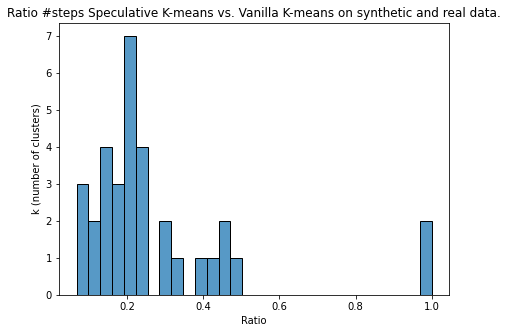

In [119]:
df = pd.read_csv('./data/sketching/multiple_executions_3_2.csv')
df['ratio'] = df['steps_choose_true'] / df['steps_choose_false']

# Plot
fig, ax = plt.subplots(figsize = (7,5))
fig = sns.histplot(data=df['ratio'], bins=30, ax = ax)
ax.set_ylabel('k (number of clusters)')
ax.set_xlabel('Ratio')
ax.set_title('Ratio #steps Speculative K-means vs. Vanilla K-means on synthetic and real data.')

plt.savefig("./figures_svg/plots_sketching/figure_section_3_2.svg", format="svg", bbox_inches='tight')

## 3.3 Dependency between ratio and n, d, k, k imposed

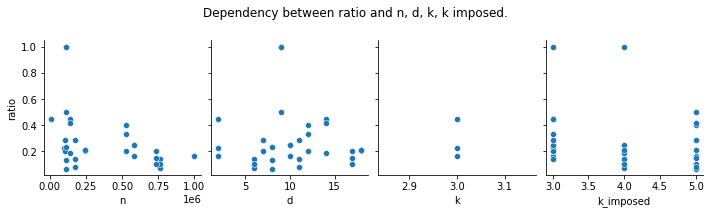

In [120]:
# Plot
g = sns.pairplot(data=df,
                  y_vars=['ratio'],
                  x_vars=['n', 'd', 'k', 'k_imposed'])

g.fig.suptitle('Dependency between ratio and n, d, k, k imposed.', y=1.15)

plt.savefig("./figures_svg/plots_sketching/figure_section_3_3.svg", format="svg", bbox_inches='tight')

From the histogram, we can see how the majority of executions has less than half steps when using the centroids suggested from the fast execution.

From the pairplots instead, we can't find any relation between the ratio and other parameters characterizing the dataset and Kmeans execution.

# 4. Further analysis

In this section we will try to stress this method to understand its limitations and its advanteges.

In particular we will:
1. Test the method over complex datasets (e.g: circles, moons, anisotropic guassian distributions). Is it performing better than simple KMeans?
2. Verify if generally KMeans with sketching performs better than KMeans
3. Measure time execution of different phases: tA_slow, tB_slow, t_sampling, t_A_fast, t_B_fast
4. Compare the number of steps between Base KMeans and Sketching KMeans for increasing k.
5. Comparison KMeans++ and KMeans sketching with centroid resampling.
6. Study effect of update weights in resampling centroids on convergence
7. Scale up

## 4.1 Complex datasets

We take as reference for finding complext datasets this page https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html, where performance of different clustering methods is compared on different datasets.

We will use the same datasets for measuring the performance of KMeans with sketching:
- Concentric circles distributions
- Moon shaped (i.e: **not convex**) distributios
- Anisotropic distributions
- Gaussian distributions with different std for each cluster
- Simple Gaussian distributions
- Not structured distribution

In [156]:
def measurements_complex_datasets(dataset_list):
    results = []
    for i, dataset in enumerate(dataset_list):
        name = dataset['name']
        X, y = dataset['dataset']
        parameters = dataset['parameters']

        # CHOOSE BEST FALSE
        # run KMeans_sketching - without best selection
        labels, centroids, steps = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, return_steps = True)
        results.append({'dataset_name':name, 'inertia' : getAvgDist(X, centroids), 'labels' : labels, 'dataset_index' : i, 'method': 'base KMeans', 'steps':steps})

        # CHOOSE BEST TRUE
        # run KMeans_sketching - with best selection
        labels, centroids, steps = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, return_steps = True)
        results.append({'dataset_name':name, 'inertia' : getAvgDist(X, centroids), 'labels' : labels, 'dataset_index' : i, 'method': 'sketching KMeans', 'steps':steps})
    return results

In [157]:
def plot_performances_complex_datasets(df, n_samples):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (18, 6))
    fig.suptitle(f'Inertia/#Steps in base KMeans and sketching KMeans, n_datapoints = {n_samples}')
    sns.barplot(data=df, x="dataset_name", y="inertia", hue = "method", ax = ax1)
    sns.barplot(data=df, x="dataset_name", y="steps", hue = "method", ax = ax2)

In [158]:
def plot_clustering(dataset_list, results):
    fig, axs = plt.subplots(len(dataset_list), 2, figsize = (12, 30))
    fig.suptitle('Clustering comparison - base KMeans vs. sketching KMeans', y = 0.9, fontsize = 16)
    for i, method in enumerate(['base KMeans', 'sketching KMeans']):
        specific_results = [result for result in results if result['method'] == method]
        for j, result in enumerate(specific_results):
            X = dataset_list[j]["dataset"][0]
            sns.scatterplot(x = X[:, 0], y = X[:, 1], hue = result['labels'], ax = axs[j, i])
            axs[j, i].set_title(f'{dataset_list[j]["name"]} - {method}')

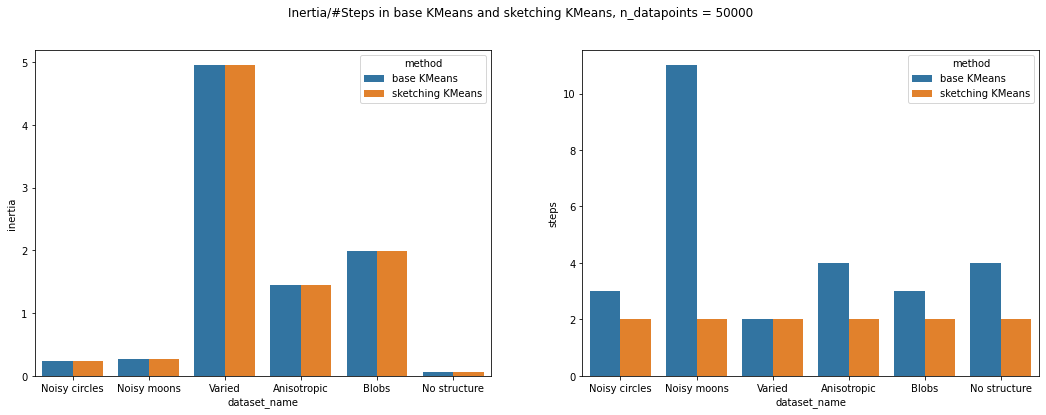

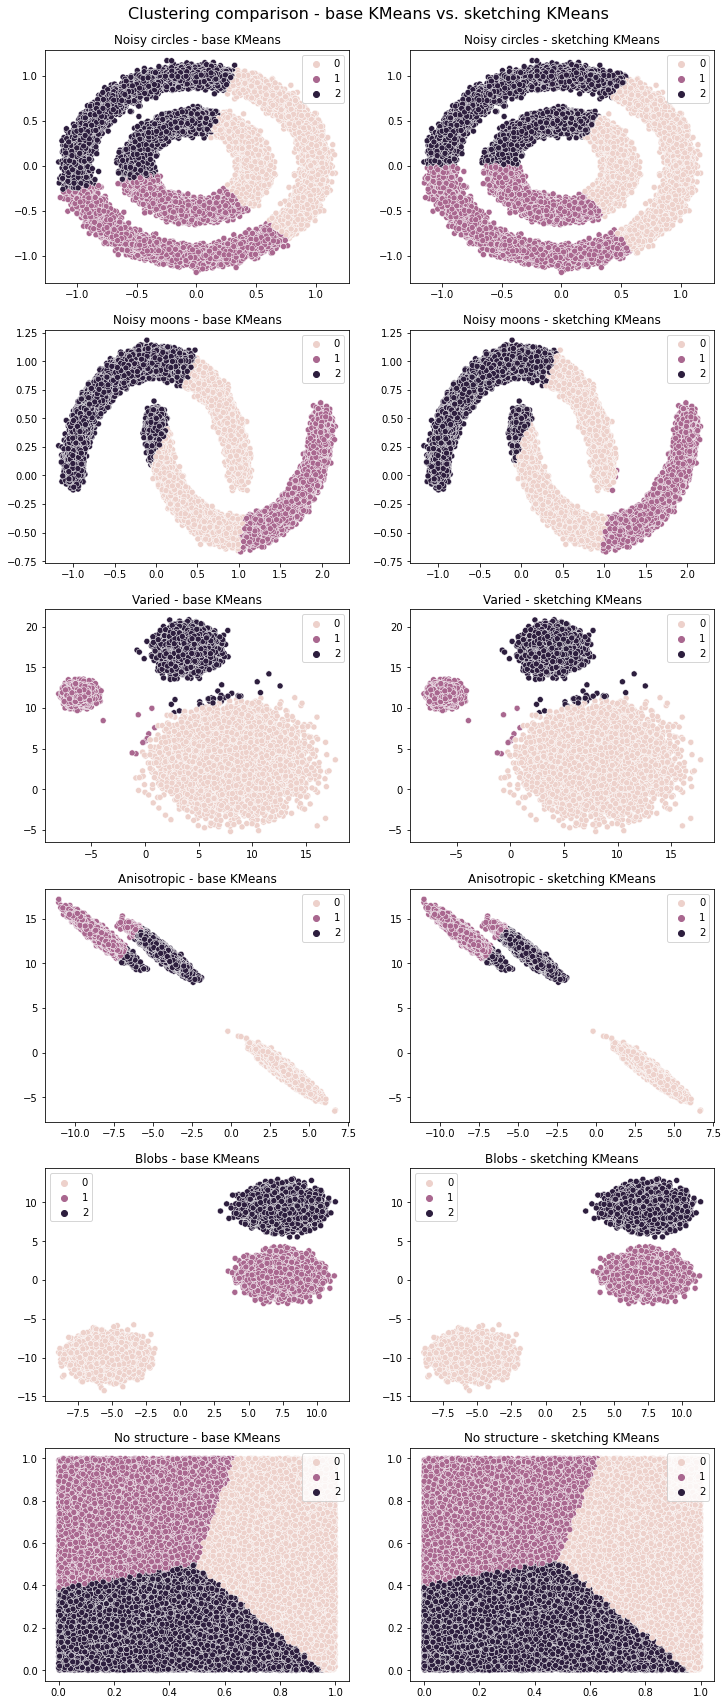

In [165]:
# set parameters
seed = 0
n_samples = 50000
k = 3
subsample_size = 0.01

# generate datasets
dataset_list = generate_complex_datasets(n_samples = n_samples, seed = seed)

# run measurements
results = measurements_complex_datasets(dataset_list)
    
df = pd.DataFrame(results)

# plot performances
plot_performances_complex_datasets(df, n_samples)

# plot clusters
plot_clustering(dataset_list, results)

From the above plots we can do the following considerations:
- There is no improvement in the value of final `inertia`. This is reasonable since in noisy circles, noisy moons and anisotropic datasets, the difficulty of KMeans of finding a good clustering is due to the fact that it uses norm 2 as a distance function, which is not able to identify clusters that have a specific shape, e.g: a non-flat manifold.
- The fact that the final `inertia` is the same can be observed also in the plots showing how the clustering is done. We can see how in both cases we get the same results in both base KMeans and sketching KMeans
- Finally we can see how generally the sketching KMeans reaches the convergence in fewer or equal steps. We can see however, a big difference in number of steps in the case of noisy moons. It looks like even if the dataset it is more challenging, sketching KMeans still manages to converge in few steps.

## 4.2 Does resampling help to escape local minima?

In this section we will study the effect of the resampling the centroids and the subset of points.

In fact, in base KMeans a bad initialization of the centers can lead to a convergence to a local minimum. However, in sketched KMeans, the fact that we are doing resampling at each step may help to escape the local minimum.

Again we do our tests taking in consideration different datasets:
- synthetic datasets, varying n, d
- synthetic datasets, varying k, k_imposed
- real datasets

>🔴 In all these cases, both Base KMeans and Sketching KMeans start from the same centroids!

### 4.2.1 Varying n, d

In [121]:
number_n = 4
number_d = 4
seed = 0
k = 3
tol = 1e-6
run = False
subsample_size = 0.01

n 10000.0
n 46415.88833612782
n 215443.46900318822
n 1000000.0


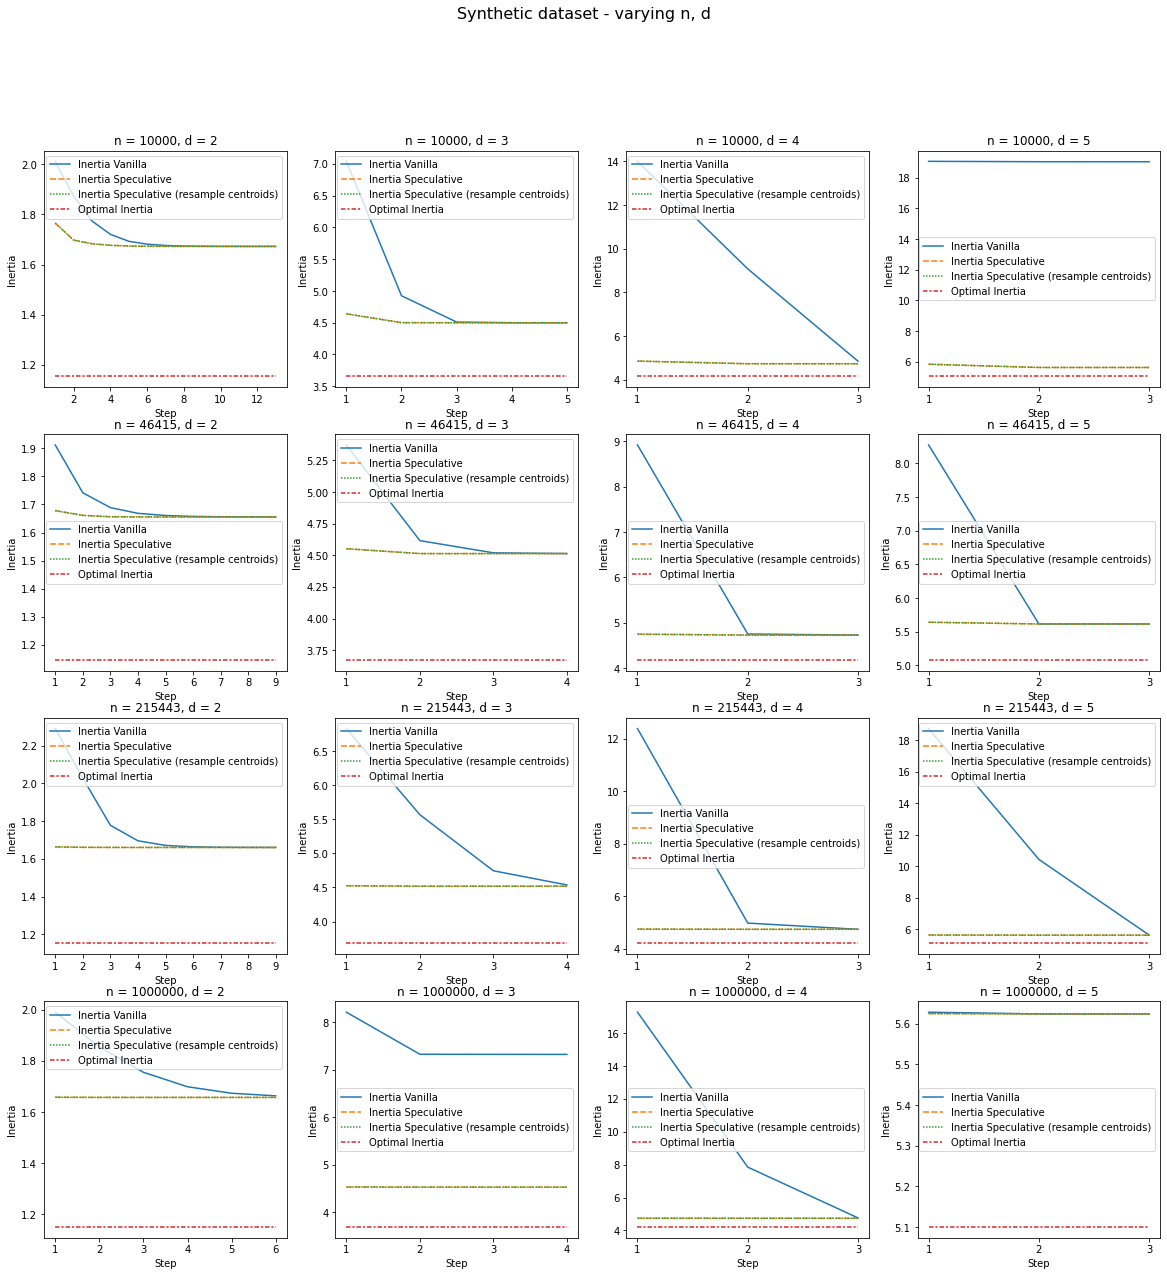

In [122]:
fig, axs = plt.subplots(number_n, number_d, figsize=(20, 20))
for i, n in enumerate(np.logspace(4, 6, num = number_n)):
    print('n', n)
    for j, d in enumerate(np.arange(number_d) + 2):
        # cast to int
        n = int(n)
        d = int(d)
        
        # save results to .csv
        path_final = f'./data/sketching/sketching_4_2_n_{n}_d_{d}.csv'
        
        # BASE EXECUTION
        if run:
            # set output path
            path = f'./data/sketching/sketching_4_2_n_{n}_d_{d}_base.csv'
            
            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)
            
            # get initial centroids
            initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

            # run 
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, tol = tol, choose_best = False, centroids=initial_centroids)
        
            # read .csv
            df1 = pd.read_csv(path)

            # SKETCHING EXECUTION
            path = f'./data/sketching/sketching_4_2_n_{n}_d_{d}_sketching.csv'
                
            # run KMeans_sketching
            # labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=True, tol = tol)
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid= False, p = 0.8, q = 0.5, centroids=initial_centroids)
            
            # read .csv
            df2 = pd.read_csv(path)
            
            # SKETCHING EXECUTION RESAMPLE CENTROIDS
            path = f'./data/sketching/sketching_4_2_n_{n}_d_{d}_sketching_resample.csv'

            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = True)
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure = True, choose_best = True, resampling = True, trace = False, tol = tol, resample_centroid = True, centroids=initial_centroids, p = 0.8, q = 0.5)

            # read .csv
            df3 = pd.read_csv(path)

            # set L_sketching
            df2['L_sketching'] = df2[['L_fast', 'L_slow']].min(axis=1)
            df2 = df2[['L_sketching']]

            # set L_sketching
            df3['L_sketching_resample'] = df3[['L_fast', 'L_slow']].min(axis=1)
            df3 = df3[['L_sketching_resample']]

            # set L_base
            df3['L_base'] = df1['L_slow']
            df3['L_sketching'] = df2['L_sketching']

            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k_imposed, seed = 0,n_init = 50, tol = 1e-6)
            
            # add L_opt
            df3['L_opt'] = getAvgDist(X, opt_centroids)
            
            df3.to_csv(path_final, index = False)
        

        # read .csv
        df3 = pd.read_csv(path_final)
        df3 = df3.rename(columns={'L_base': 'Inertia Vanilla', 'L_sketching': 'Inertia Speculative', 'L_sketching_resample': 'Inertia Speculative (resample centroids)' , 'L_opt': 'Optimal Inertia'})
        
        # create subplot
        axs[i, j].set_title(f'n = {n}, d = {d}')
        timeseries_plot(df3[['Inertia Vanilla', 'Inertia Speculative', 'Inertia Speculative (resample centroids)', 'Optimal Inertia']], xlabel='Step', ylabel='Inertia', ax = axs[i, j], show=False)

        
fig.suptitle('Synthetic dataset - varying n, d', fontsize=16)        
# plt.savefig('./figures/sketching_4_2_n_d_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_4_2_1.svg", format="svg", bbox_inches='tight')

### 4.2.2 Varying k, k_imposed

We take:
- `k` in the range [3, 7]
- `k_imposed` in the range [3, 7]

In [123]:
number_k = 4
number_k_imp = 4
seed = 0
n = int(1e5)
d = 3
run = False
subsample_size = 0.01
tol = 1e-6

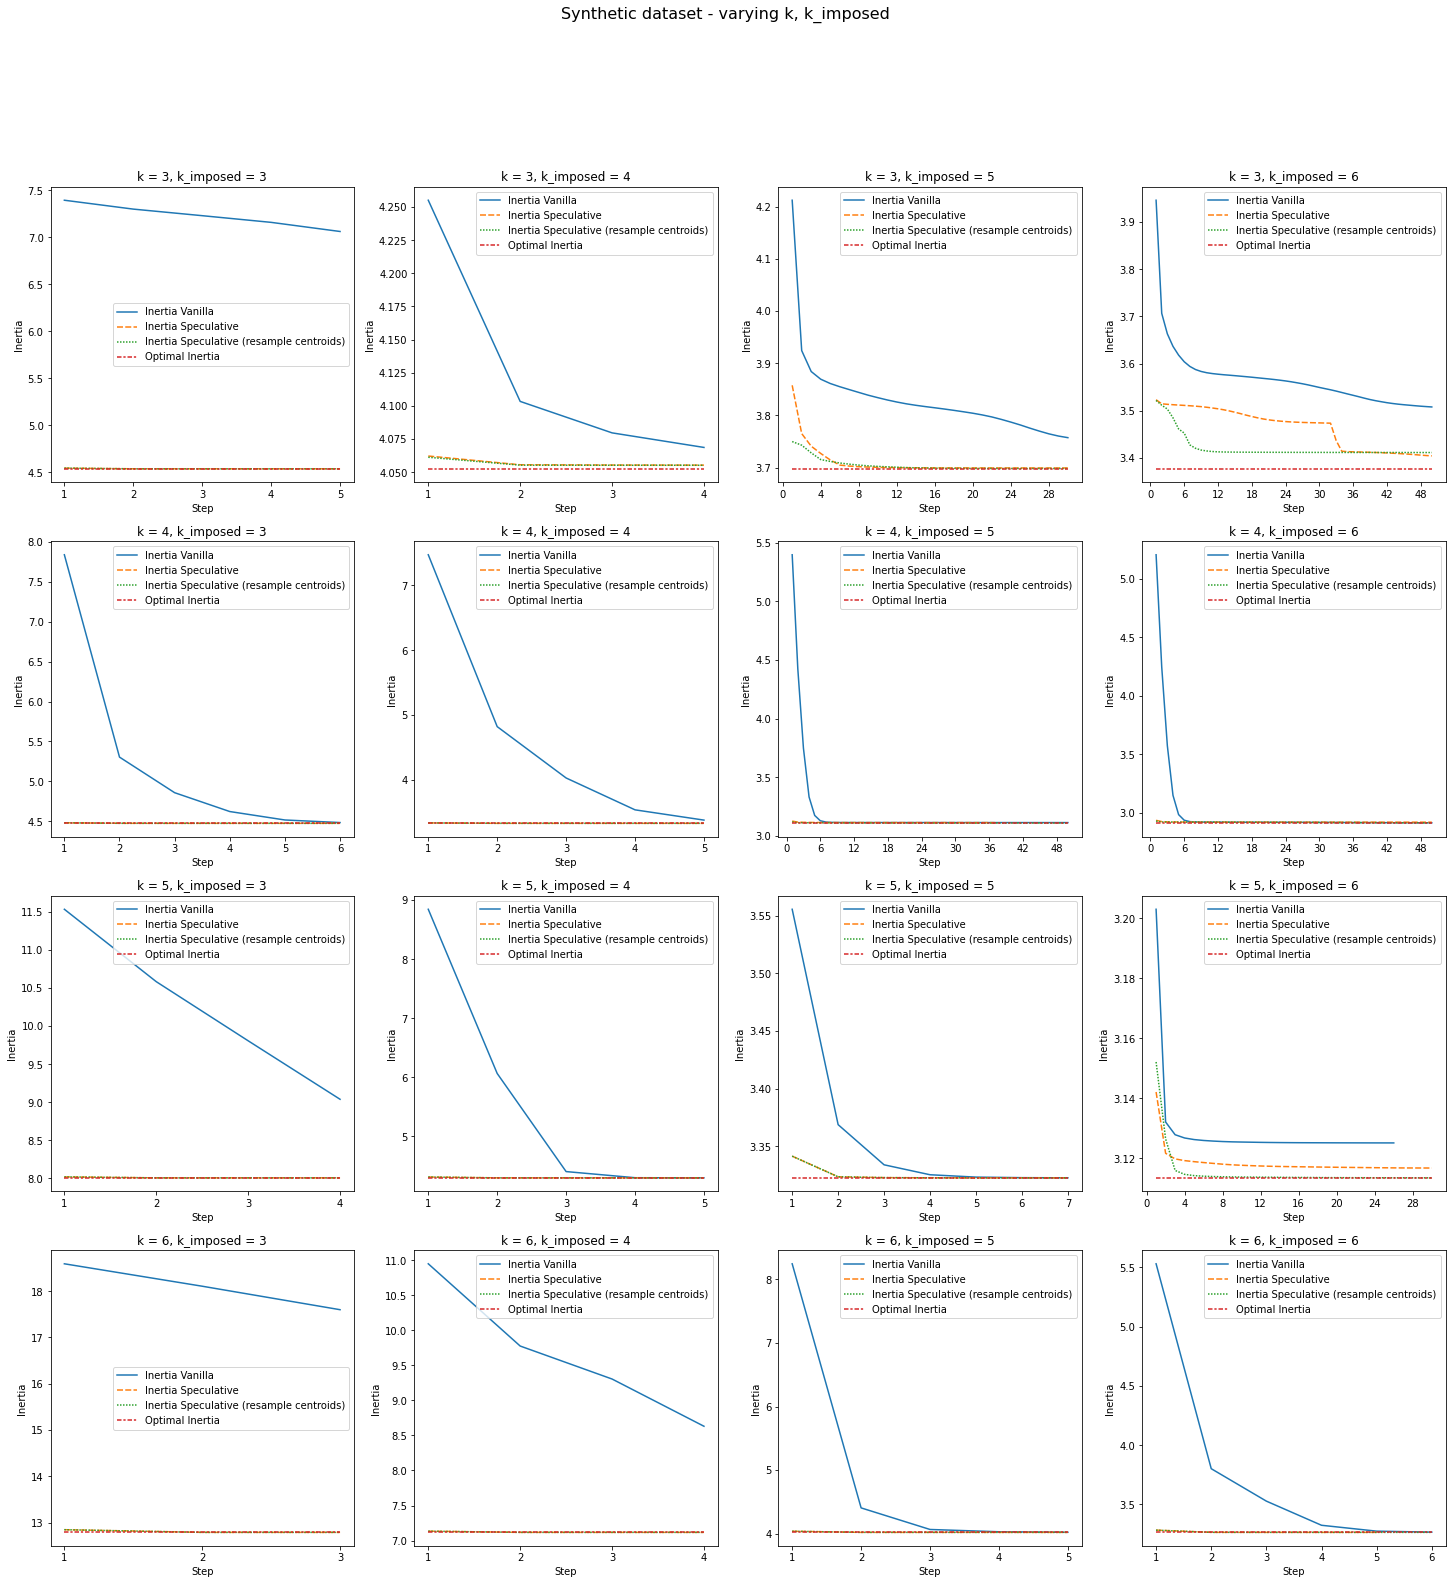

In [124]:
fig, axs = plt.subplots(number_k, number_k_imp, figsize=(25, 25))
for i, k in enumerate(np.arange(number_k) + 3):
    for j, k_imposed in enumerate(np.arange(number_k_imp) + 3):
        # cast to int
        k = int(k)
        k_imposed = int(k_imposed)
        
        # save results to .csv
        path_final = f'./data/sketching/sketching_4_2_k_{k}_k_imposed_{k_imposed}.csv'
        
        # BASE EXECUTION
        if run:
            # set output path
            path = f'./data/sketching/sketching_4_2_k_{k}_k_imposed_{k_imposed}_base.csv'

            # create synthetic dataset
            true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)
            
            # get initial centroids
            initial_centroids = X[np.random.choice(n, k_imposed, replace=False)]  # (k, d)

            # run basic
            labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, tol = tol, choose_best = False, centroids=initial_centroids)

            # read .csv
            df1 = pd.read_csv(path)

            # SKETCHING EXECUTION
            path = f'./data/sketching/sketching_4_2_k_{k}_k_imposed_{k_imposed}_sketching.csv'

            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = False)
            labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid=False, p = 0.8, q = 0.5, centroids=initial_centroids)

            # read .csv
            df2 = pd.read_csv(path)


            # SKETCHING EXECUTION RESAMPLE CENTROIDS
            path = f'./data/sketching/sketching_4_2_k_{k}_k_imposed_{k_imposed}_sketching_resample.csv'

            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = True)
            labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid = True, p = 0.8, q = 0.5, centroids=initial_centroids)

            # read .csv
            df3 = pd.read_csv(path)


            # set L_sketching
            df2['L_sketching'] = df2[['L_fast', 'L_slow']].min(axis=1)
            df2 = df2[['L_sketching']]

            # set L_sketching
            df3['L_sketching_resample'] = df3[['L_fast', 'L_slow']].min(axis=1)
            df3 = df3[['L_sketching_resample']]

            # set L_base
            df3['L_base'] = df1['L_slow']
            df3['L_sketching'] = df2['L_sketching']

            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k_imposed, seed = 0,n_init = 50, tol = 1e-6)
            
            # add L_opt
            df3['L_opt'] = getAvgDist(X, opt_centroids)
            
            df3.to_csv(path_final, index = False)
        
        # read .csv
        df3 = pd.read_csv(path_final)
        df3 = df3.rename(columns={'L_base': 'Inertia Vanilla', 'L_sketching': 'Inertia Speculative', 'L_sketching_resample': 'Inertia Speculative (resample centroids)' , 'L_opt': 'Optimal Inertia'})
        
        # create subplot
        axs[i, j].set_title(f'k = {k}, k_imposed = {k_imposed}')
        timeseries_plot(df3[['Inertia Vanilla', 'Inertia Speculative', 'Inertia Speculative (resample centroids)', 'Optimal Inertia']], xlabel='Step', ylabel='Inertia', ax = axs[i, j], show=False)
        
fig.suptitle('Synthetic dataset - varying k, k_imposed', fontsize=16)        
# plt.savefig('./figures/sketching_2_2_k_k_imposed_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_4_2_2.svg", format="svg", bbox_inches='tight')

### 4.2.3 Real datasets

In [106]:
# load datasets
query = "NumberOfInstances > 100000 &\
         NumberOfInstances < 1000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

# # import downloaded datasets
# X_list = load_downloaded_datasets()

dataset number 0
dataset number 1
dataset number 2
dataset number 3
dataset number 4
dataset number 5
dataset number 6
dataset number 7
dataset number 8
dataset number 9


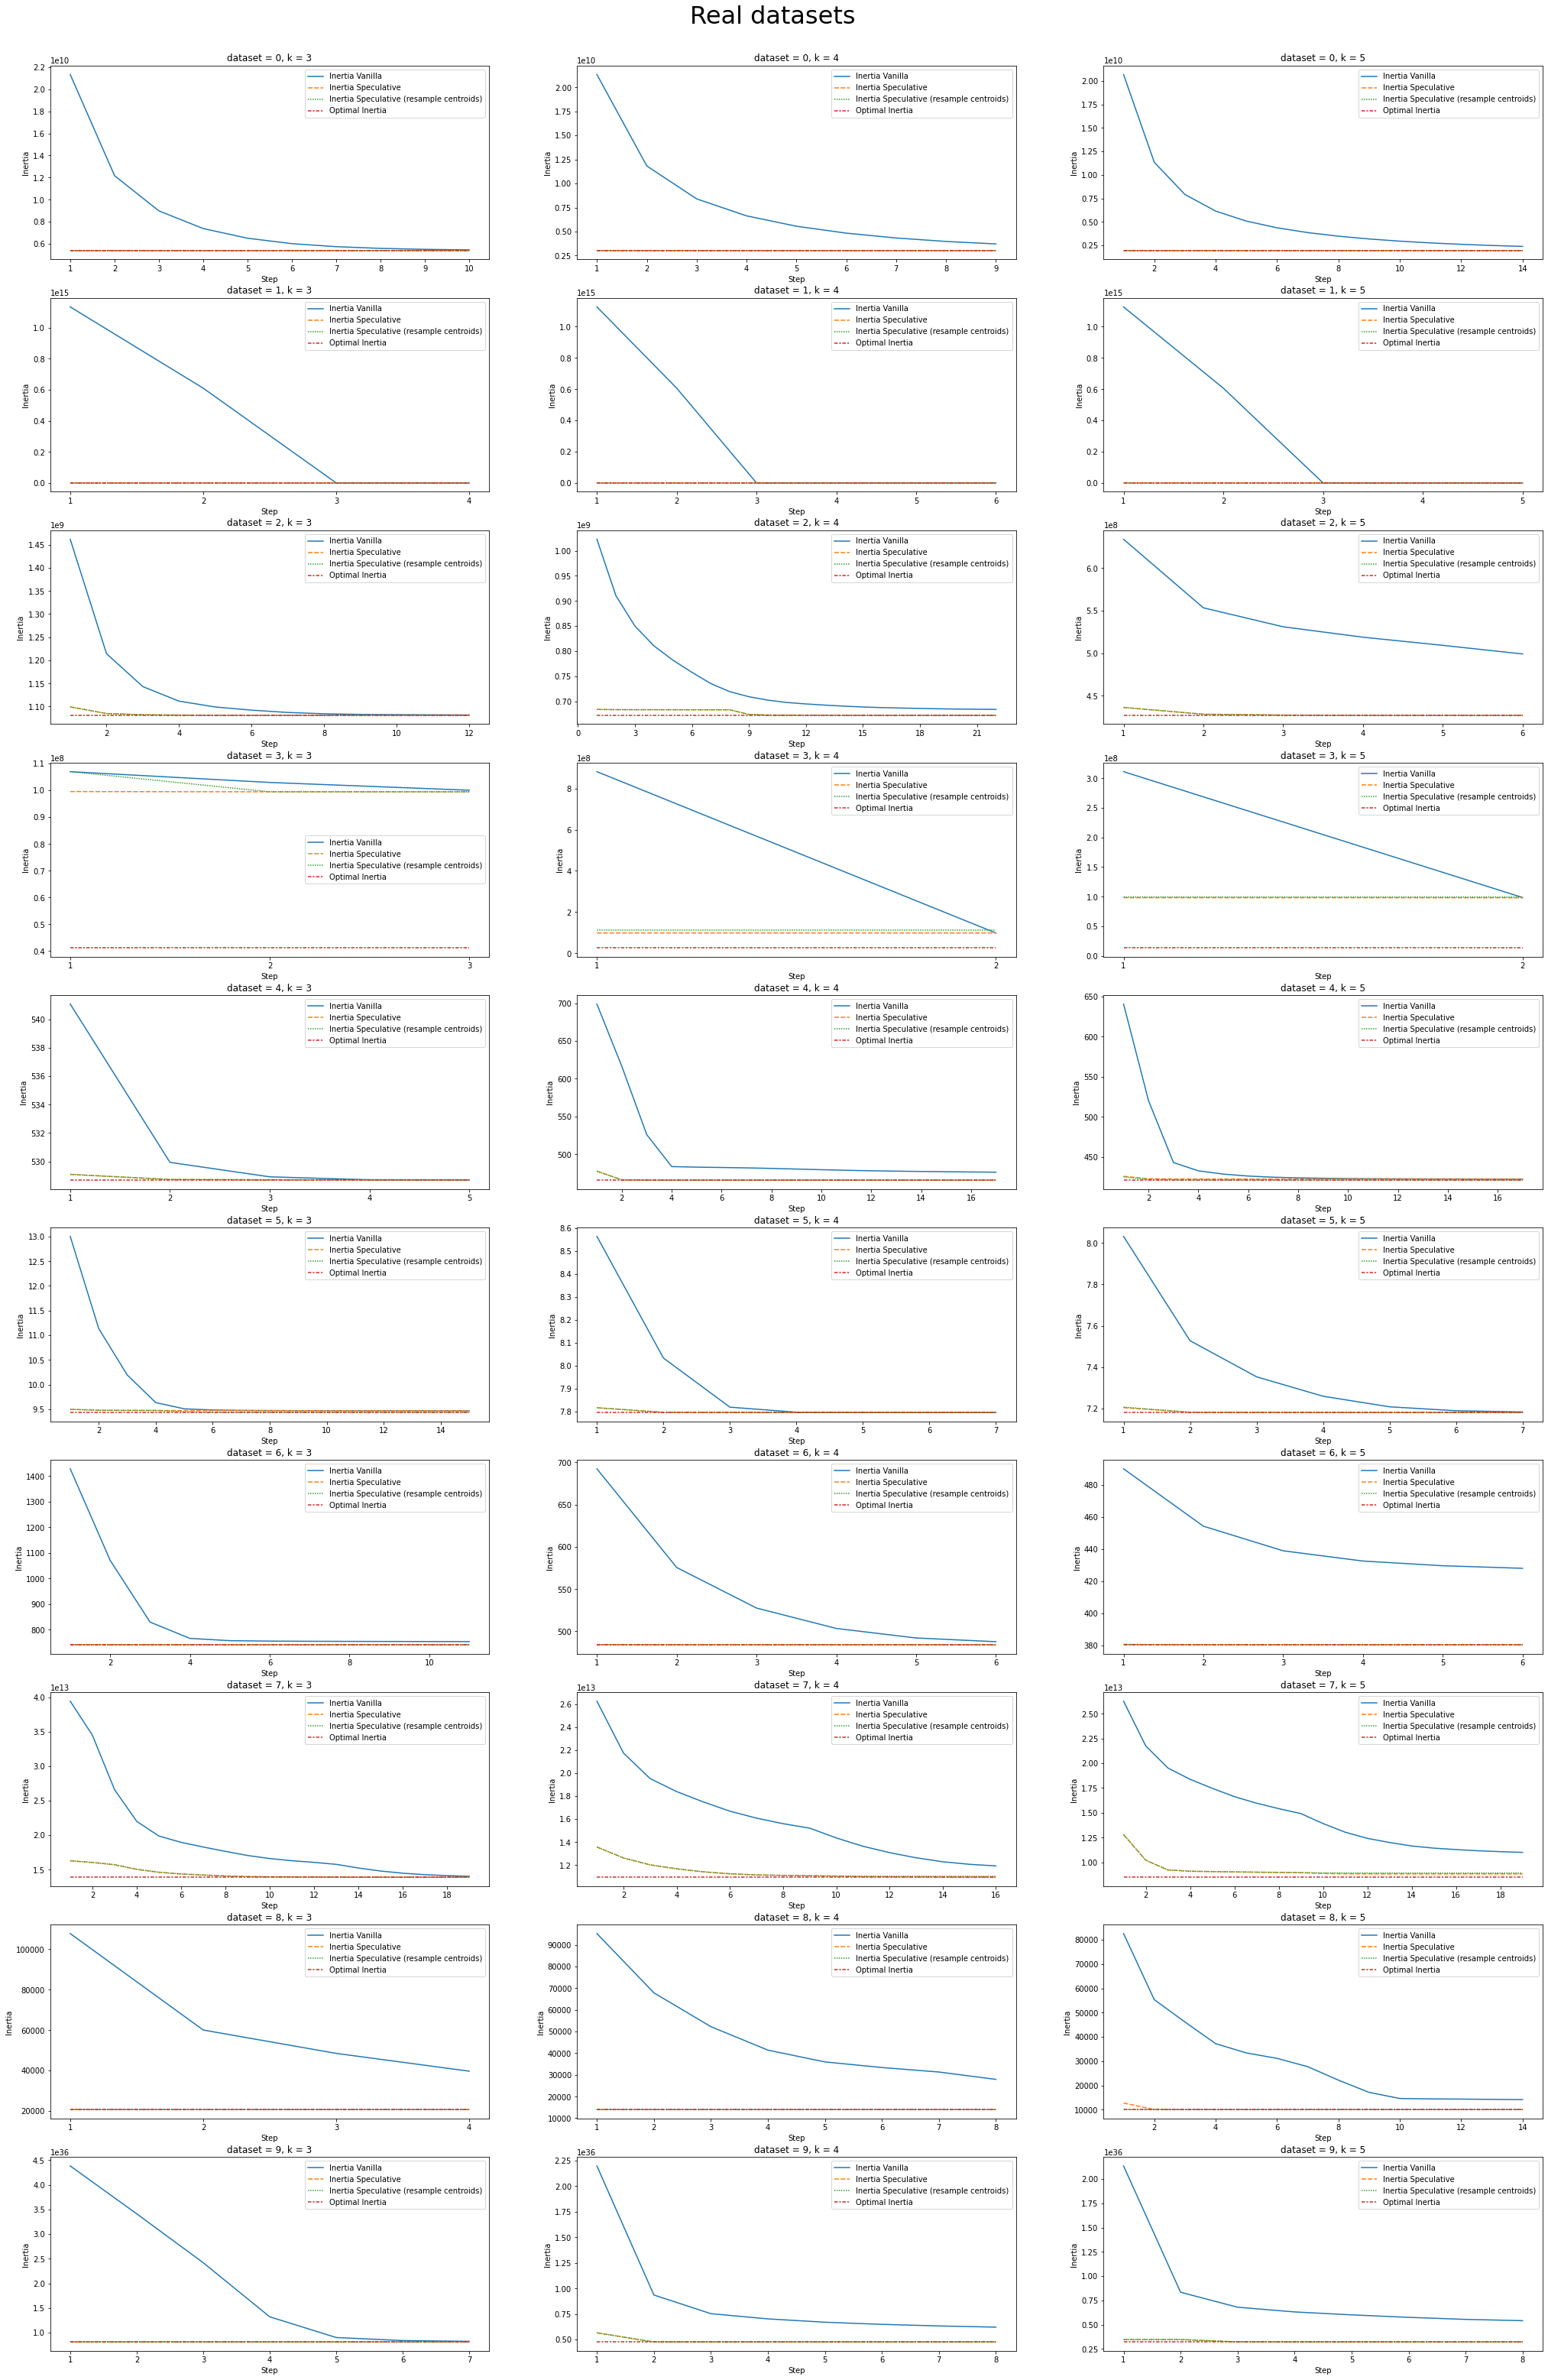

In [125]:
# set seed
seed = 0
subsample_size = 0.01
run = False
tol = 1e-6

fig, axs = plt.subplots(len(X_list), 3, figsize=(35, 55))
for i, X in enumerate(X_list):
    print('dataset number', i)
    for j, k in enumerate(range(3,6)):
        # save results to .csv
        path_final = f'./data/sketching/sketching_4_2_dataset_{i}_k_{k}.csv'
        if run:
            # BASE EXECUTION
            
            # get initial centroids
            initial_centroids = X[np.random.choice(n, k, replace=False)]  # (k, d)

            # set output path
            path =f'./data/sketching/sketching_4_2_dataset_{i}_k_{k}_base.csv'
            
            # run KMeans_base
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, tol = tol, centroids=initial_centroids)

            # read .csv
            df1 = pd.read_csv(path)

            # SKETCHING EXECUTION
            path = f'./data/sketching/sketching_4_2_dataset_{i}_k_{k}_sketching.csv'

            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid = False)
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid=False, p = 0.8, q = 0.5, centroids=initial_centroids)

            # read .csv 
            df2 = pd.read_csv(path)

            # SKETCHING EXECUTION - RESAMPLE CENTROIDS
            path = f'./data/sketching/sketching_4_2_dataset_{i}_k_{k}_sketching_resample.csv'

            # run KMeans_sketching
           #labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure= True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid = True)
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, save = True, path = path, measure=True, choose_best = True, resampling = True, trace=False, tol = tol, resample_centroid = True, p = 0.8, q = 0.5, centroids=initial_centroids)

            # read .csv 
            df3 = pd.read_csv(path)

            # set L_sketching
            df2['L_sketching'] = df2[['L_fast', 'L_slow']].min(axis=1)
            df2 = df2[['L_sketching']]
            df3['L_sketching_resample_centroids'] = df3[['L_fast', 'L_slow']].min(axis=1)

            # set L_base
            df3['L_base'] = df1['L_slow']
            df3['L_sketching'] = df2['L_sketching']


            # estimate optimal centroids
            opt_centroids = estimate_optimal_centroids(X, k, seed = 0,n_init = 50, tol = 1e-6)
            # add L_opt
            df3['L_opt'] = getAvgDist(X, opt_centroids)
            
            df3.to_csv(path_final, index = False)
        
        # read .csv
        df3 = pd.read_csv(path_final)
        df3 = df3.rename(columns={'L_base': 'Inertia Vanilla', 'L_sketching': 'Inertia Speculative', 'L_sketching_resample_centroids': 'Inertia Speculative (resample centroids)' , 'L_opt': 'Optimal Inertia'})

        # create subplot
        axs[i, j].set_title(f'dataset = {i}, k = {k}')
        df3.fillna(method='ffill', inplace = True)
        df3 = df3[['Inertia Vanilla', 'Inertia Speculative', 'Inertia Speculative (resample centroids)', 'Optimal Inertia']]
        timeseries_plot(df3, xlabel='Step', ylabel='Inertia', ax = axs[i, j], show=False)

fig.suptitle('Real datasets', fontsize=32, y = 0.9)        
# plt.savefig('./figures/sketching_2_3_figure')
plt.savefig("./figures_svg/plots_sketching/figure_section_4_2_3.svg", format="svg", bbox_inches='tight')

## 4.3 Measuring time executions

In this section we are interested into understanding the relation of time executions.

In particular we want to see 2 things:
- if effectively `t_sketching` ≅ `t_A` + `t_B`
- what is the ratio `t_sampling`/`t_A` or `t_sampling`/`t_B`

We are just going to run different KMeans with sketching on different types of datasets.

Our expectations are the following:
- `t_sketching` ≅ `t_A` + `t_B` holds
- `t_sampling`/`t_A` is very small (around 1e-2, 1e-3) and `t_sampling`/`t_B` is around 1e0, 1e-1

In [ ]:
# load datasets
query = "NumberOfInstances > 1000000 &\
         NumberOfInstances < 10000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

# # import downloaded datasets
# X_list = load_downloaded_datasets()

In [69]:
# set seed
seed = 0
subsample_size = 0.01
run = False

number_k = 3
number_k_imp = 3
number_n = 3
number_d = 3

counter = 0

df = pd.DataFrame()

# SYNTHETIC DATASETS
for n in np.logspace(5, 7, num = number_n):
    for d in (np.arange(number_d)*3 + 2):
        for k in (np.arange(number_k)*3 + 3):
            for k_imposed in (np.arange(number_k_imp)*3 + 3):
                # cast to int
                n = int(n)
                d = int(d)
                k = int(k)
                k_imposed = int(k_imposed)
                                
                # create synthetic dataset
                true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)
                
                # path
                path =f'./data/sketching/sketching_4_3_dataset_{counter}.csv'

                if run:
                    # CHOOSE BEST TRUE
                    labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True, path = path)
                
                # read .csv
                df_tmp = pd.read_csv(path)
                
                # concat measurements
                df = pd.concat([df, df_tmp])
                
                # print progression
                if counter % 10 == 0:
                    print(counter)
                
                counter += 1
        
# REAL DATASETS
for i, X in enumerate(X_list):
    # set parameters
    n, d = X.shape
    for j, k in enumerate(range(3,6)):
        # path
        path =f'./data/sketching/sketching_4_3_dataset_{counter}.csv'
        
        if run:
            # CHOOSE BEST TRUE
            labels, centroids = KMeans_sketching(X, k, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True,path = path)

        # read .csv
        df_tmp = pd.read_csv(path)

        # concat measurements
        df = pd.concat([df, df_tmp])
        
        # print progression
        if counter % 10 == 0:
            print(counter)
        
        counter += 1
        
df.to_csv('./data/sketching/measurements_4_3.csv', index=False)

0
10
20
30
40
50
60
70
80
90
100


In [24]:
# read measurements
df = pd.read_csv('./data/sketching/measurements_4_3.csv')

#### t_sketching

We now verify the assumption we made at the beginning of this study, i.e:
- `t_sketching` ≅ `t_A` + `t_B`

Where in t_sketching we use `subsample_size` of the data, and we execute t_A and t_B `n_executions` = int(np.floor(1/`subsample_size`)) times.

<AxesSubplot:xlabel='difference', ylabel='Count'>

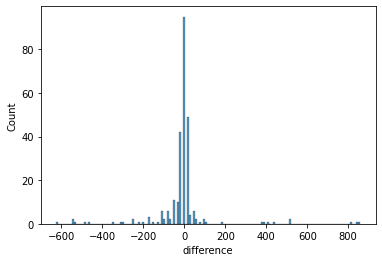

In [18]:
# compute sum of time execution
df['t_AB'] = df['t_A'] + df['t_B']
# keep only measurements with positive value
df = df[df['t_AB'] > 0]
# compute difference between t_sketching and t_AB
df['difference'] = df['t_sketching'] - df['t_AB']
# plot histogram
sns.histplot(df.difference)

In [19]:
print('Mean: %.2f' % np.mean(df['difference']))
print('Median: %.2f' % np.median(df['difference']))
print('Std: %.2f' % np.std(df['difference']))
print('Average absolute difference from mean: %.2f' % np.mean(np.abs((df['difference']) - np.mean(df['difference']))))

Mean: -6.67
Median: 0.00
Std: 149.13
Average absolute difference from mean: 61.05


From the histogram we can observe how the majority of values covered by `difference` (i.e: `t_sketching` - `t_AB`) is around 0.
In particular we have that:
- the mean is -6.7, i.e: t_sketching is on average faster than t_AB, which is good, because we want to finish the sketching parallel execution at maximum together with the slow execution
- the median is 0
- the std is 149.13
- the average absolute difference from the mean is 61.03

This is a good result since it means that generally we finish the parallel fast execution before or together with the slow one.

However, **in an actual implementation we would use signals to stop the fast execution as soon the slow execution would have finished!**

#### t_A, t_B, t_sampling

At the moment:
- we already know that t_A and t_B scale with `n`, `d`, `k`. In particular we have **t_A: O(ndk)**, **t_B: O(d(n+k))**
- we expect t_sampling to depend only on `n`. In particular we expect **t_sampling: O(n)**

We repeat the measurements changing only 1 parameter at the time.

In [147]:
# set seed
seed = 0
subsample_size = 0.01
run = False

number_k = 10
number_k_imp = 10
number_n = 10
number_d = 10

df = pd.DataFrame()

counter = 0

# SYNTHETIC DATASETS
k = 3
d = 5
k_imposed = 3
for n in np.logspace(5, 7, num = number_n):
    # cast to int
    n = int(n)
    d = int(d)
    k = int(k)
    k_imposed = int(k_imposed)

    # create synthetic dataset
    true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

    # path
    path =f'./data/sketching/sketching_4_3_dataset_{counter}_t_sampling.csv'

    if run:
        # CHOOSE BEST TRUE
        labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True, path = path)

    # read .csv
    df_tmp = pd.read_csv(path)
    
    df_tmp['variable'] = 'n'

    # concat measurements
    df = pd.concat([df, df_tmp])
        
    # print progression
    if counter % 10 == 0:
        print(counter)

    counter += 1
    
n = 1e7
k = 3
k_imposed = 3
for d in (np.arange(number_d) + 2):
    # cast to int
    n = int(n)
    d = int(d)
    k = int(k)
    k_imposed = int(k_imposed)

    # create synthetic dataset
    true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

    # path
    path =f'./data/sketching/sketching_4_3_dataset_{counter}_t_sampling.csv'

    if run:
        # CHOOSE BEST TRUE
        labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True, path = path)

    # read .csv
    df_tmp = pd.read_csv(path)
    
    df_tmp['variable'] = 'd'

    # concat measurements
    df = pd.concat([df, df_tmp])
    
    # print progression
    if counter % 10 == 0:
        print(counter)

    counter += 1

n = 1e7
d = 5
k_imposed = 3
for k in (np.arange(number_k) + 3):
    # cast to int
    n = int(n)
    d = int(d)
    k = int(k)
    k_imposed = int(k_imposed)

    # create synthetic dataset
    true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

    # path
    path =f'./data/sketching/sketching_4_3_dataset_{counter}_t_sampling.csv'

    if run:
        # CHOOSE BEST TRUE
        labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True, path = path)

    # read .csv
    df_tmp = pd.read_csv(path)
    
    df_tmp['variable'] = 'k'

    # concat measurements
    df = pd.concat([df, df_tmp])
    
    # print progression
    if counter % 10 == 0:
        print(counter)

    counter += 1
    
n = 1e7
d = 5
k = 3   
for k_imposed in (np.arange(number_k_imp) + 3):
    # cast to int
    n = int(n)
    d = int(d)
    k = int(k)
    k_imposed = int(k_imposed)

    # create synthetic dataset
    true_centroids, _, X, y = generate_clusters(n_clusters=k, d=d, n=n, seed = seed)

    # path
    path =f'./data/sketching/sketching_4_3_dataset_{counter}_t_sampling.csv'

    if run:
        # CHOOSE BEST TRUE
        labels, centroids = KMeans_sketching(X, k_imposed, num_iter=50, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace = True, measure_time = True, measure = True, save = True, path = path)

    # read .csv
    df_tmp = pd.read_csv(path)
    
    df_tmp['variable'] = 'k_imposed'

    # concat measurements
    df = pd.concat([df, df_tmp])
    
    # print progression
    if counter % 10 == 0:
        print(counter)

    counter += 1
    
df.to_csv('./data/sketching/measurements_4_3_t_sampling.csv', index=False)
df = pd.read_csv('./data/sketching/measurements_4_3_t_sampling.csv')

0
10
20
30


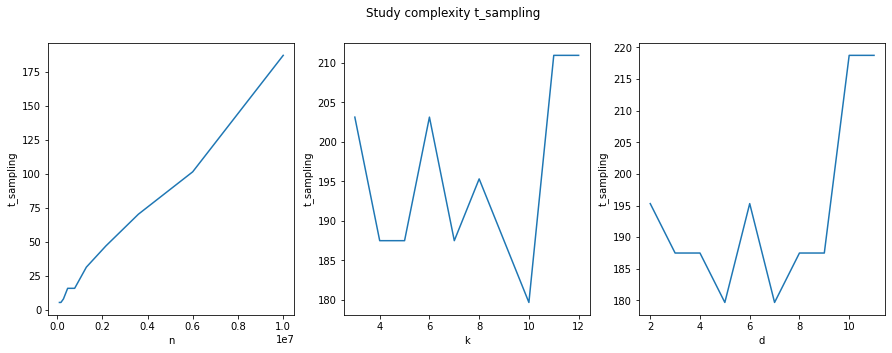

In [148]:
# plot t_sampling complexity


df['ratio_sampling_A'] = df['t_sampling']/df['t_A']
df['ratio_sampling_B'] = df['t_sampling']/df['t_B']

df_n = df[df.variable == 'n']
df_k = df[df.variable == 'k_imposed']
df_d = df[df.variable == 'd']

fig, ax = plt.subplots(1, 3, figsize = (15,5))
fig.suptitle('Study complexity t_sampling')
agg_and_plot(df_n, 'n', 't_sampling', ax = ax[0])
agg_and_plot(df_k, 'k', 't_sampling', ax = ax[1])
agg_and_plot(df_d, 'd', 't_sampling', ax = ax[2])

From the plot we can see how there is a clear linear dependency of `t_sampling` with `n` whereas there is not with `d` and `k`.
- in 'n' we increase from 25ms to 175ms
- in 'd' and 'k', we fixed 'n' = 1e7, and indeed we see how the t_sampling stays around the value 200, which was reached in the first plot at `n` = 1e7

Now given that t_sampling is O(n) we expect that:
- the ratios t_sampling/t_A and t_sampling/t_B are constant with n
- the ratios t_sampling/t_A and t_sampling/t_B are decreasing with k
- the ratios t_sampling/t_A and t_sampling/t_B are decreasing with d

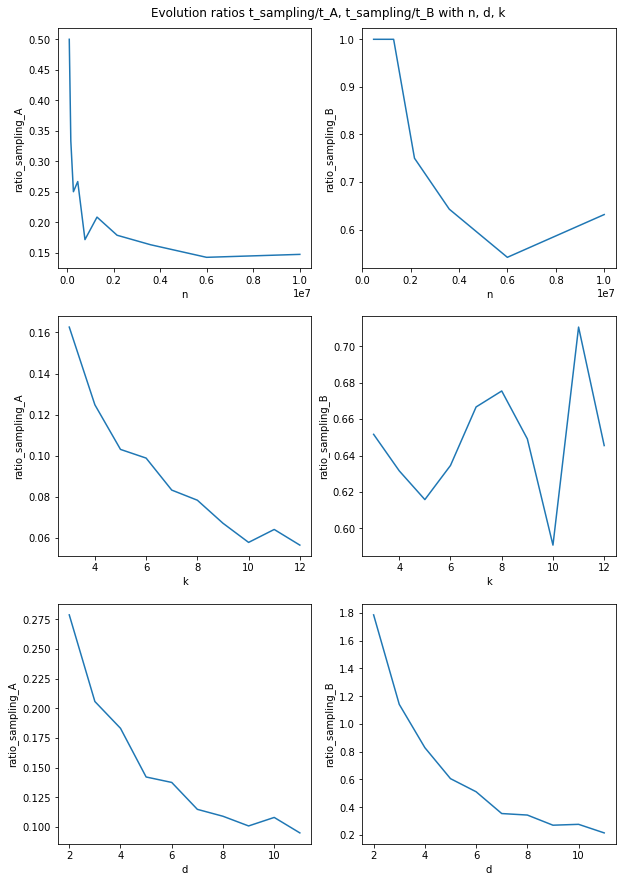

In [150]:
# plot evolution with n

fig, ax = plt.subplots(3, 2, figsize = (10,15))
fig.suptitle('Evolution ratios t_sampling/t_A, t_sampling/t_B with n, d, k', y = 0.9)
agg_and_plot(df_n, 'n', 'ratio_sampling_A', ax = ax[0, 0])
agg_and_plot(df_n, 'n', 'ratio_sampling_B', ax = ax[0, 1])

agg_and_plot(df_k, 'k', 'ratio_sampling_A', ax = ax[1, 0])
agg_and_plot(df_k, 'k', 'ratio_sampling_B', ax = ax[1, 1])

agg_and_plot(df_d, 'd', 'ratio_sampling_A', ax = ax[2, 0])
agg_and_plot(df_d, 'd', 'ratio_sampling_B', ax = ax[2, 1])

Our expectations are met since:
- the ratios t_sampling/t_A and t_sampling/t_B are constant with n
- the ratios t_sampling/t_A and t_sampling/t_B are decreasing with k
- the ratios t_sampling/t_A and t_sampling/t_B are decreasing with d

Still, we have some noise in the plot of the second row, second column. Here we see how by varying k, the ratio t_sampling/t_B has some peaks.

## 4.4 #Steps Kmeans, Sketching KMeans with increasing k

We measure the steps in sketching with both:
- resampling centroids `False`
- resampling centroids `True`
- hybrid
- kmeans_pp

We expect the algorithm to take more steps when we resampling the centroids.

In [59]:
# load datasets
query = "NumberOfInstances > 100000 &\
         NumberOfInstances < 1000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

# # import downloaded datasets
# X_list = load_downloaded_datasets()

In [60]:
# set seed
seed = 0
subsample_size = 0.01
run = False
tol = 1e-6
path = './data/sketching/steps_list_4_4.pickle'
num_iter = 200

steps_list = []

if run:
    for i, X in enumerate(X_list):
        steps = {'k': [], 'base': [], 'sketching': [], 'sketching_resampling_centroids' : [], 'sketching_hybrid' : [], 'sketching_kmeans_pp' : []}
        for k in range(3,20):
            print(f'd_id: {i}, k: {k}')
            
            print('\tbase')
            # run KMeans_base
            labels, centroids, steps_base = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size = subsample_size, tol = tol, return_steps = True)
            steps['base'].append(steps_base)
            
            print('\tsketching')            
            # run KMeans_sketching - no resampling centroids
            labels, centroids, steps_sketching = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = False, return_steps = True)
            steps['sketching'].append(steps_sketching)
            
            print('\tsketching w\ resampling of centroids')
            # run KMeans_sketching yes resamping centroids
            labels, centroids, steps_sketching = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = True, return_steps = True)
            steps['sketching_resampling_centroids'].append(steps_sketching)
            
#             print('\tsketching hybrid')
#             # run KMeans_sketching yes resamping centroids - with hybrid
#             labels, centroids, steps_sketching = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = True, return_steps = True, hybrid = True)
#             steps['sketching_hybrid'].append(steps_sketching)
            
#             print('\tsketching kmeans ++')
#             # run KMeans_sketching no resamping centroids - with Kmeans ++ initialization
#             labels, centroids, steps_sketching = KMeans_sketching(X, k, num_iter=num_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = False, return_steps = True, hybrid = False, kmeans_pp = True)
#             steps['sketching_kmeans_pp'].append(steps_sketching)
            
            steps['k'] = k
            
            steps_list.append(steps)
            
            with open(path, 'wb') as handle:
                pickle.dump(steps_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    
with open(path, 'rb') as handle:
    steps_list = pickle.load(handle)

Text(0.5, 0.98, 'Steps evolution over k')

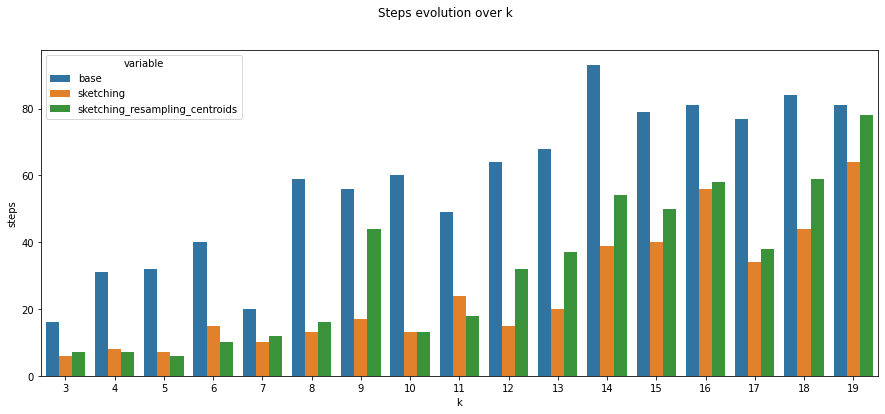

In [168]:
# build df from dictionaries
df = pd.DataFrame()
for i, step in enumerate(steps_list):
    df_steps = pd.DataFrame(step)
    df_steps['dataset_id'] = i
    df_steps['k'] = np.arange(3,20)
    df = pd.concat([df, df_steps])

df_agg = df.groupby('k').agg({'base':np.median, 'sketching':np.median, 'sketching_resampling_centroids':np.median}).reset_index()
df_melt = pd.melt(df_agg, id_vars=['k'], value_vars=['base', 'sketching', 'sketching_resampling_centroids'], value_name = 'steps')

# plot
fig, ax = plt.subplots(figsize=(15,6))
sns.barplot(data=df_melt, x="k", y="steps", hue="variable", ax = ax)
fig.suptitle('Steps evolution over k')

## 4.5 Comparing resampling centroids with KMeans++

In section 4.2 we saw how we were able to escape the convergence to a local minimum using:
- resampling of datapoints evertime before the fast execution
- resampling the centroids evertime before the fast execution

Other techniques are used to avoid local minima, like in KMeans++.

In KMeans++ the choice of the initial centroids is such that they are spread out over the dataset, i.e: they are not one near the other.
This is done with a particular algorithm for choosing the centroids:
The exact algorithm is as follows:

1. Choose one center uniformly at random among the data points.
2. For each data point x not chosen yet, compute D(x), the distance between x and the nearest center that has already been chosen.
3. Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)2.
4. Repeat Steps 2 and 3 until k centers have been chosen.
5. Now that the initial centers have been chosen, proceed using standard k-means clustering.

We can see how the step n. 2 corresponds to A, the assignment phase, where we need to compute the minimum distance between each datapoint, and the current chosen centroids.
This is repeated `k - 1` times.
Even if the assignment A is not done with all `k - 1` centroids everytime (indeed, we first compute the assignment with only 1 centroid, then with 2 etc...), this is still a heavy computational step.

The hope is that the time spent in the beginning would pay off by making KMeans converging to the optimum minimum.

The technique used in KMeans Sketching could be an alternative, since instead of paying an additional time at the beginning, we spread the cost on more steps of KMeans.
We saw that the resampling of the centroids sometimes causes the convergence to take more steps, but the overall time cost may be less then the one of KMeans ++.

This section tries therefore to understand if generally Sketching KMeans performs better.
We will compare:
- the amount steps taken by KMeans++ and KMeans Sketching
- the total time taken by KMeans++ and KMeans Sketching
- the inertia on the final solution of KMeans++ and KMeans Sketching

We will use the real datasets for this analysis.

In [56]:
# load datasets
query = "NumberOfInstances > 100000 &\
         NumberOfInstances < 1000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

# # import downloaded datasets
# X_list = load_downloaded_datasets()

In [170]:
seed = 0
tol = 1e-6
max_iter = 50
subsample_size = 0.01
run = False
FACTOR = 1e+06
measurements = {'steps_kmeans_pp': [], 'steps_kmeans_sketching' : [], 't_kmeans_pp': [], 't_kmeans_sketching': [], 'inertia_kmeans_pp': [], 'inertia_kmeans_sketching': [], 'optimal_inertia': [],
               'sketching_t_A': [], 'sketching_t_B' : [], 'sketching_t_sampling': [], 'sketching_t_sampling_centroids': [], 'sketching_t_get_avg': [], 'sketching_t_permutation': [], 'sketching_t_choose_best': []}
path_pickle = './data/sketching/measurements_4_5_update_algorithm.pickle'

if run:
    for i, X in enumerate(X_list):
        print(i)
        print(f'\t',end='')
        for k in range(3, 10):
            print(f'{k} ',end='')
            
            # measurements on KMeans++ execution
            start = process_time_ns()
            labels_pp, centroids_pp, steps_pp = KMeans(X, k, num_iter = max_iter, seed = seed, kmeans_pp = True, tol = tol, return_steps = True)
            end = process_time_ns()
            measurements['t_kmeans_pp'].append((end-start)/FACTOR)
            measurements['steps_kmeans_pp'].append(steps_pp)
            measurements['inertia_kmeans_pp'].append(getAvgDist(X, centroids_pp))

            # measurements on KMeans with sketching and centroids resampling
            path = f'./data/sketching/section_4_4_dataset_{i}_k_{k}.csv'
            labels, centroids = KMeans_sketching(X, k, num_iter = max_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = True, save = True, path=path, measure = True, measure_time = True, kmeans_pp = False)
            
            df = pd.read_csv(path)
            measurements['steps_kmeans_sketching'].append(df.steps.values[0])
            measurements['t_kmeans_sketching'].append((df['t_A'] + df['t_B'] + df['t_sampling'] + df['t_choose_best']
                                                       + df['t_sampling_centroids']
                                                       + df['t_get_avg'] + df['t_permutation']).sum())
            measurements['inertia_kmeans_sketching'].append(getAvgDist(X, centroids))
            
            measurements['optimal_inertia'].append(getAvgDist(X, estimate_optimal_centroids(X, k, seed = 0, n_init = 50, tol = tol)))
            
            measurements['sketching_t_A'].append(df['t_A'].sum())
            measurements['sketching_t_B'].append(df['t_B'].sum())
            measurements['sketching_t_sampling'].append(df['t_sampling'].sum())
            measurements['sketching_t_sampling_centroids'].append(df['t_sampling_centroids'].sum())
            measurements['sketching_t_get_avg'].append(df['t_get_avg'].sum())
            measurements['sketching_t_permutation'].append(df['t_permutation'].sum())
            measurements['sketching_t_choose_best'].append(df['t_choose_best'].sum())
            
            # measurements on KMeans with sketching without centroids resampling but with KMeans++ initialization
            path = f'./data/sketching/section_4_4_dataset_{i}_k_{k}_no_resampling_centroids.csv'
            labels, centroids = KMeans_sketching(X, k, num_iter = max_iter, seed=seed, subsample_size = subsample_size, choose_best = True, resampling = True, trace=True, tol = tol, resample_centroid = False, save = True, path=path, measure = True, measure_time = True, kmeans_pp = True)
            
            df = pd.read_csv(path)

            measurements['inertia_sketching_no_resampling_centroids'].append(getAvgDist(X, centroids))
            measurements['steps_sketching_no_resampling_centroids'].append(df.steps.values[0])
            measurements['t_sketching_no_resampling_centroids'].append((df['t_A'] + df['t_B'] + df['t_sampling'] + df['t_choose_best']
                                                       + df['t_sampling_centroids']
                                                       + df['t_get_avg'] + df['t_permutation']).sum())

            with open(path_pickle, 'wb') as handle:
                pickle.dump(measurements, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(path_pickle, 'rb') as handle:
    measurements = pickle.load(handle)
    df = pd.DataFrame(measurements)

Text(0.5, 1.0, 'Histogram Time Ratio t_kmeans_pp/t_kmeans_sketching')

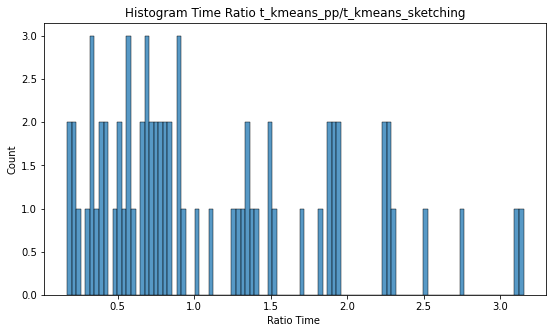

In [171]:
# plot histogram of time difference between t_kmeans_pp and t_kmeans_sketching
df['ratio_pp_sketching'] = (df['t_kmeans_pp'])/df['t_kmeans_sketching']
fig, ax = plt.subplots(figsize=(9,5))
sns.histplot(df['ratio_pp_sketching'], bins = 100, ax = ax)
ax.set_xlabel('Ratio Time ')
ax.set_title('Histogram Time Ratio t_kmeans_pp/t_kmeans_sketching')

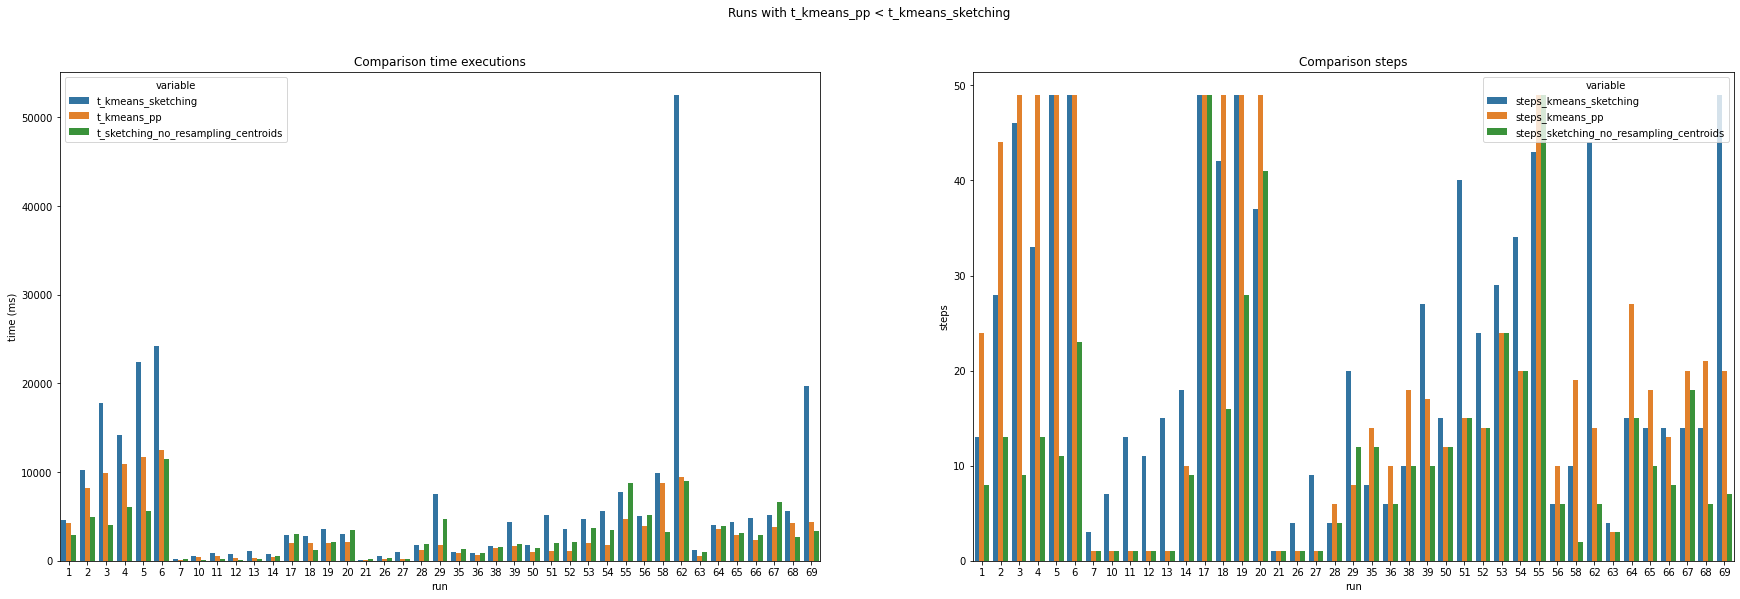

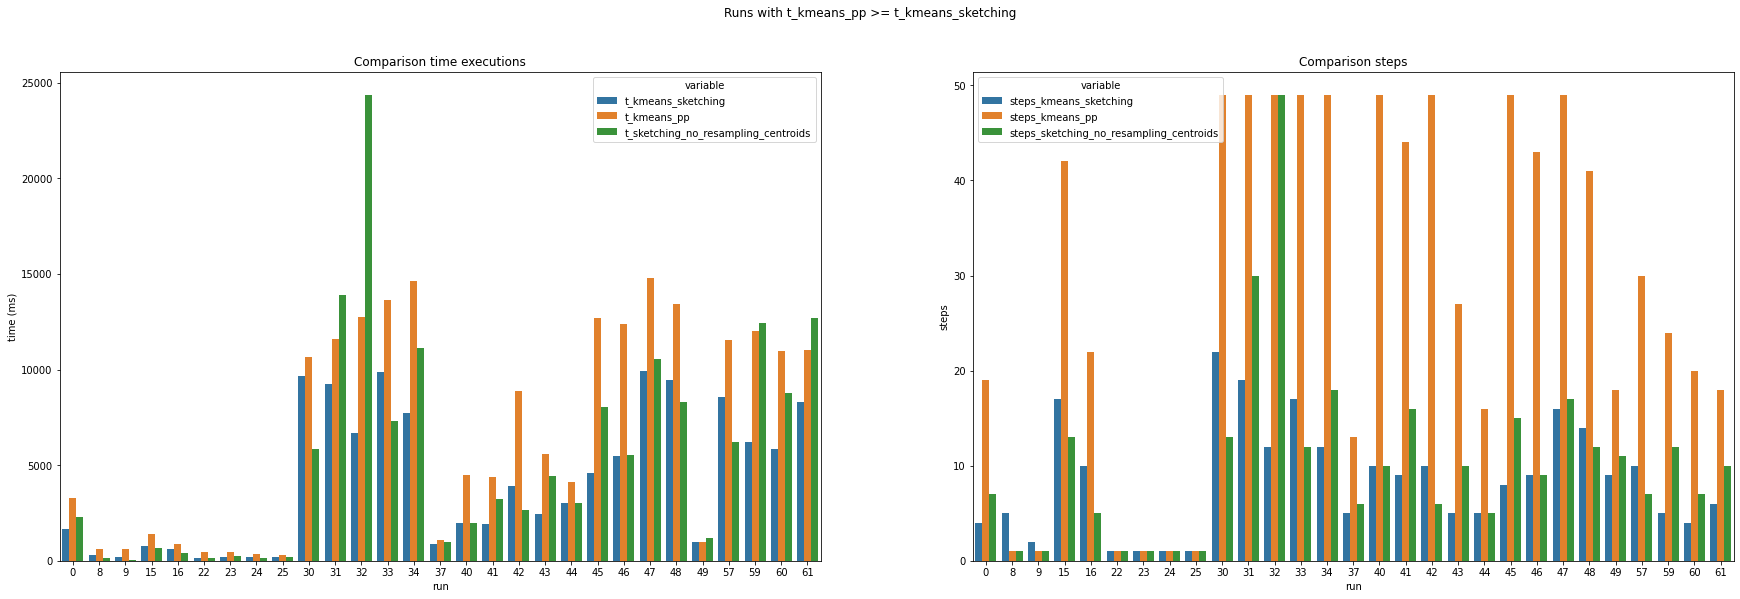

In [116]:
# melt data
mask1 = df.t_kmeans_pp < df.t_kmeans_sketching
mask2 = df.t_kmeans_pp >= df.t_kmeans_sketching
def plot_comparison(mask, title):
    df2 = pd.melt(df[mask].reset_index(), id_vars=['index'], value_vars=['steps_kmeans_sketching', 'steps_kmeans_pp', 'steps_sketching_no_resampling_centroids'])
    df2.rename(columns = {'index':'run', 'value':'steps'}, inplace=True)
    df3 = pd.melt(df[mask].reset_index(), id_vars=['index'], value_vars=['t_kmeans_sketching', 't_kmeans_pp', 't_sketching_no_resampling_centroids'])
    df3.rename(columns = {'index':'run', 'value':'time (ms)'}, inplace=True)

    # plot
    fig, ax = plt.subplots(1, 2, figsize=(30,9))
    sns.barplot(data=df3, x="run", y="time (ms)", hue="variable", ax = ax[0])
    ax[0].set_title('Comparison time executions')
    sns.barplot(data=df2, x="run", y="steps", hue="variable", ax = ax[1])
    ax[1].set_title('Comparison steps')
    fig.suptitle(title)

plot_comparison(mask1, 'Runs with t_kmeans_pp < t_kmeans_sketching')
plot_comparison(mask2, 'Runs with t_kmeans_pp >= t_kmeans_sketching')

Text(0.5, 0.98, 'Analysis of time execution of different sections of Sketching')

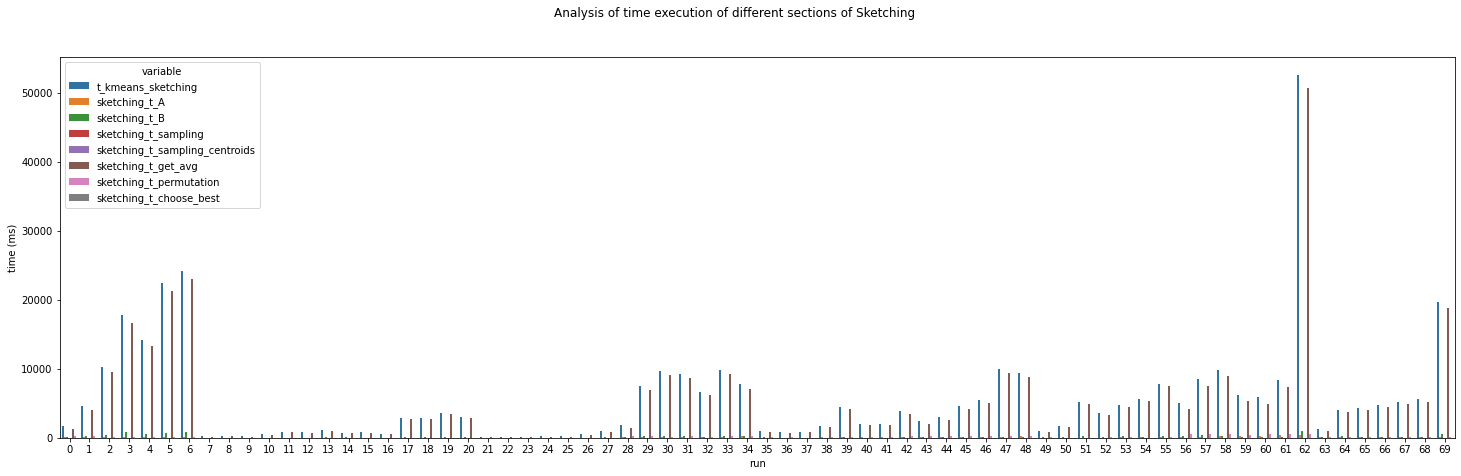

In [117]:
columns = ['t_kmeans_sketching', 'sketching_t_A', 'sketching_t_B',
       'sketching_t_sampling', 'sketching_t_sampling_centroids',
       'sketching_t_get_avg', 'sketching_t_permutation',
       'sketching_t_choose_best']

df2 = pd.melt(df.reset_index(), id_vars=['index'], value_vars=columns)
df2.rename(columns = {'index':'run', 'value':'time (ms)'}, inplace=True)

# plot
fig, ax = plt.subplots(1, figsize=(25,7))
sns.barplot(data=df2, x="run", y="time (ms)", hue="variable", ax = ax)
fig.suptitle('Analysis of time execution of different sections of Sketching')

Text(0.5, 1.1, 'Analysis of inertia of final solutions')

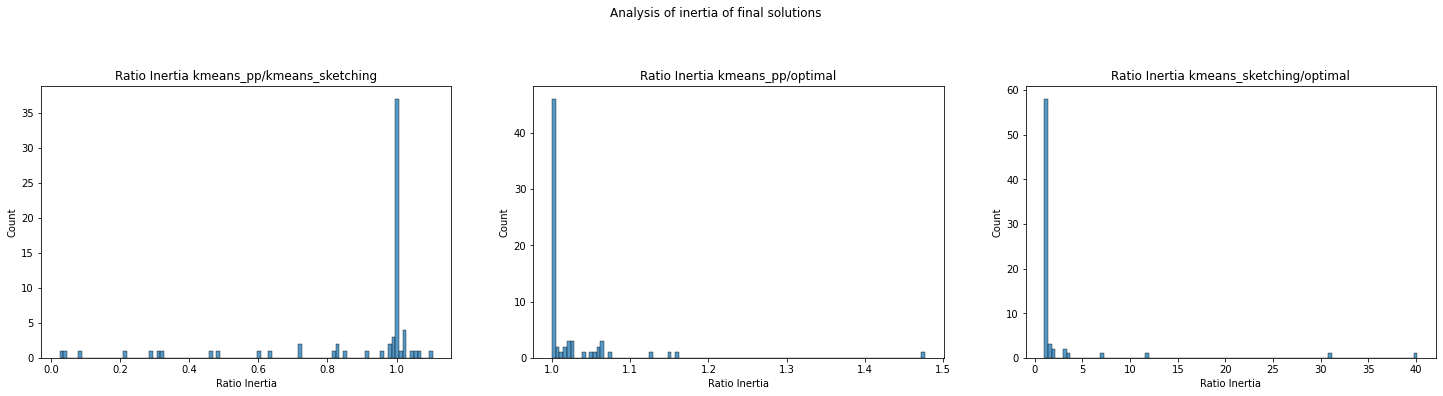

In [178]:
# analysis of inertia of final solutions
df['ratio_inertia_pp_sketching'] = (df['inertia_kmeans_pp'])/df['inertia_kmeans_sketching']
df['ratio_inertia_pp_optimal'] = (df['inertia_kmeans_pp'])/df['optimal_inertia']
df['ratio_inertia_sketching_optimal'] = (df['inertia_kmeans_sketching'])/df['optimal_inertia']
fig, axes = plt.subplots(1, 3, figsize=(25,5))

# inertia_kmeans_pp - inertia_kmeans_sketching
sns.histplot(df['ratio_inertia_pp_sketching'], bins = 100, ax = axes[0])
axes[0].set_xlabel('Ratio Inertia')
axes[0].set_title('Ratio Inertia kmeans_pp/kmeans_sketching')

# inertia_kmeans_pp - optimal_inertia
sns.histplot(df['ratio_inertia_pp_optimal'], bins = 100, ax = axes[1])
axes[1].set_xlabel('Ratio Inertia')
axes[1].set_title('Ratio Inertia kmeans_pp/optimal')

# inertia_kmeans_sketching - optimal_inertia
sns.histplot(df['ratio_inertia_sketching_optimal'], bins = 100, ax = axes[2])
axes[2].set_xlabel('Ratio Inertia')
axes[2].set_title('Ratio Inertia kmeans_sketching/optimal')

fig.suptitle('Analysis of inertia of final solutions', y = 1.1)

## 4.6 Study resampling centroids, with different weights p

The implementation of **resampling centroids** consist on having a slightly different intial centroid in the fast execution. In particular in consist on:
- having the previous selected centroids `fast_centroids`
- resampling random centroids `resampled_centroid`
- combine them linearly, with different weights `fast_centroids` = `p`\*`fast_centroids` + `(1-p)`\*`resampled_centroid`, in order to move randomly the initial `fast_centroids`

The intensity of the resampling is regulated with the parameter `p`.
- the higher `p`, the more the centroids used correspond to the original
- the smaller `p`, the more the centroids used are randomly sampled

We added this feature in order to exploit the fast execution in order to escape from local minima we may converge to, due to a bad centroid intialization.

We want to study more in depth the influence of parameter `p`.

In particular we would expect:
- With `p` around 0
    1. To escape more often local minima
    2. To have more steps
- With 'p' around 1
    1. To escae rarely local minima
    2. To have fewer steps

In [2]:
# load datasets
query = "NumberOfInstances > 100000 &\
         NumberOfInstances < 1000000 &\
         NumberOfNumericFeatures > 5 &\
         NumberOfNumericFeatures < 50 &\
         NumberOfMissingValues == 0 &\
         NumberOfSymbolicFeatures == 0"

X_list = load_datasets(query, n_datasets = 10, search = True)

# # import downloaded datasets
# X_list = load_downloaded_datasets()

In [139]:
k = 10
tol = 1e-6
seed = 0
iteration = 10
max_iter = 50
path = './data/sketching/measurement_list_4_6.pickle'
run = False

In [120]:
measurement_list = []
if run:
    for i, X in enumerate(X_list):
        initial_centroids = find_bad_initalization(X, k, tol = tol, seed = seed, iteration = iteration, max_iter = max_iter)
        for p in np.linspace(0, 1, num=10):
            measurement = {'p' : [], 'steps': [], 'inertia': []}
            print(f'dataset_id: {i}, p: {p}')
            labels, centroids, steps = KMeans_sketching(X, k, num_iter = max_iter, seed = seed, subsample_size = 0.01, choose_best = True, resampling = True, trace=True, tol = tol, return_steps = True, resample_centroid = True, p = p, centroids = initial_centroids)
            inertia = getAvgDist(X, centroids)
            measurement['p'] = p
            measurement['steps'] = steps
            measurement['inertia'] = inertia
            measurement_list.append(measurement)

            with open(path, 'wb') as handle:
                    pickle.dump(measurement_list, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
    
with open(path, 'rb') as handle:
    measurement_list = pickle.load(handle)

Text(0.5, 1.0, 'Inertia evolution over p')

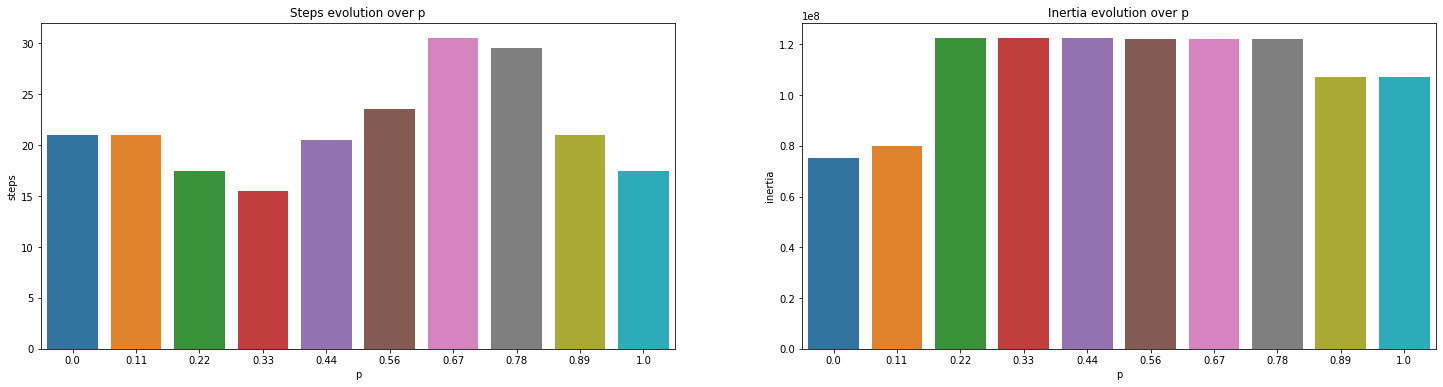

In [181]:
df = pd.DataFrame(measurement_list)
df = df.round(2)
df_agg = df.groupby('p').agg({'steps':np.median, 'inertia':np.median}).reset_index()

# plot
fig, ax = plt.subplots(1, 2, figsize=(25,6))
sns.barplot(data=df_agg, x="p", y="steps", ax = ax[0])
ax[0].set_title('Steps evolution over p')

sns.barplot(data=df_agg, x="p", y="inertia", ax = ax[1])
ax[1].set_title('Inertia evolution over p')